In [ ]:

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
! pip install umap-learn
! pip install chart-studio
pip uninstall plotly

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

## Cluster Visualization
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE, Isomap, MDS
from yellowbrick.cluster import KElbowVisualizer ,SilhouetteVisualizer
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.metrics import davies_bouldin_score,make_scorer,adjusted_rand_score
from pandas.plotting import parallel_coordinates
from sklearn.model_selection import GridSearchCV
from statistics import mean

## data preprocessing

from sklearn.preprocessing import MinMaxScaler,StandardScaler,QuantileTransformer
from scipy import stats
from sklearn.preprocessing import PowerTransformer

#import chart_studio.plotly as py
import plotly.graph_objs as go

# Cluster Algorithms
from sklearn.cluster import KMeans, OPTICS,AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Defaults
import warnings
warnings.filterwarnings("ignore")

cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#Download dataframes 
df_Olist_T1= pd.read_csv('/content/drive/MyDrive/Fatma Aidi/Parcours OCR/Data/df_Olist_T1.csv')
df_Olist_T2= pd.read_csv('/content/drive/MyDrive/Fatma Aidi/Parcours OCR/Data/df_Olist_T2.csv')
df_Olist_T3= pd.read_csv('/content/drive/MyDrive/Fatma Aidi/Parcours OCR/Data/df_Olist_T3.csv')
df_Olist= pd.read_csv('/content/drive/MyDrive/Fatma Aidi/Parcours OCR/Data/df_Olist_T4.csv')
df_all= pd.read_csv('/content/drive/MyDrive/Fatma Aidi/Parcours OCR/Data/df_Olist.csv')

# Fonction

In [ ]:

def scaled(df):
  #PowerTransformer with box-cox method
  pt = PowerTransformer(method='box-cox',  standardize=False,)#yeo-johnson
  pt.fit(df)## # Fitting the model
  data=pt.transform(df)

  # standardize dataframe 
  scaler_minmax=MinMaxScaler()
  scaler_Standard=StandardScaler()
  scaler_Quantile=QuantileTransformer()
  
  # fit_transform
  data_scaled_minmax= scaler_minmax.fit_transform(data)
  data_scaled_minmax = pd.DataFrame(data_scaled_minmax)
  data_scaled_minmax.columns = df.columns

  data_scaled_Standard= scaler_Standard.fit_transform(data)
  data_scaled_Standard = pd.DataFrame(data_scaled_Standard)
  data_scaled_Standard.columns = df.columns

  data_scaled_Quantile= scaler_Quantile.fit_transform(data)
  data_scaled_Quantile = pd.DataFrame(data_scaled_Quantile) 
  data_scaled_Quantile.columns = df.columns

  return data_scaled_minmax,data_scaled_Standard,data_scaled_Quantile

In [ ]:

def scaled_johnson(df):
  #PowerTransformer with yeo-johnson method
  pt = PowerTransformer(method='yeo-johnson',  standardize=False,)#yeo-johnson
  pt.fit(df)## # Fitting the model
  data=pt.transform(df)

  # standardize the dateframe 
  scaler_minmax=MinMaxScaler()
  scaler_Standard=StandardScaler()
  scaler_Quantile=QuantileTransformer()
  
  # fit_transform
  data_scaled_minmax= scaler_minmax.fit_transform(data)
  data_scaled_minmax = pd.DataFrame(data_scaled_minmax)
  data_scaled_minmax.columns = df.columns

  data_scaled_Standard= scaler_Standard.fit_transform(data)
  data_scaled_Standard = pd.DataFrame(data_scaled_Standard)
  data_scaled_Standard.columns = df.columns

  data_scaled_Quantile= scaler_Quantile.fit_transform(data)
  data_scaled_Quantile = pd.DataFrame(data_scaled_Quantile) 
  data_scaled_Quantile.columns = df.columns

  return data_scaled_minmax,data_scaled_Standard,data_scaled_Quantile

In [ ]:
import statistics 

def score_ari(df,model, nb_itr=6):
    # Fitting the model
    model.fit(df)
    labels_true=model.labels_
    # Calculate the ARI scores 
    ARI_scores = []
    # Iterating
    for i in range(0,nb_itr):       
        # Fitting the model
        model.fit(df)
        labels_predict= model.labels_
        # Compute the ARI score with labels_true
        ARI_score= adjusted_rand_score(labels_predict,labels_true)
        ARI_scores.append(ARI_score)
    #Compute the mean of ARI scores
    ARI_mean = statistics.mean(ARI_scores)
    return ARI_mean

In [ ]:
def stability(df,model, nb_itr=6):

    from sklearn.metrics.cluster import adjusted_rand_score
    import statistics

    # Fitting the model
    model.fit(df)
    labels_true=model.labels_

    # Calculate the ARI scores 
    ARI_scores = []

    # Iterating
    for i in range(0,nb_itr):
        
        # Fitting the model
        model.fit(df)

        labels_predict= model.labels_
        # Compute the ARI score with labels_true
        ARI_score= adjusted_rand_score(labels_predict,labels_true)
        ARI_scores.append(ARI_score)

    #Compute the mean of ARI scores
    ARI_mean = statistics.mean(ARI_scores)
    Sc=silhouette_score(df, model.labels_)

    return ARI_mean,Sc

In [ ]:
#plot silhouette_score,  davies_bouldin_score and inertia 

def k_number(df,methode):

  WSS = []
  db = []
  sil = []
  K = range(2, 10)
  for i in K:
      km = KMeans(n_clusters=i,init='random', n_init = 10 ,max_iter=100, 
                          tol=0.0001,  random_state= 40  , algorithm='auto' )
  
      km.fit(df)
      labels = km.labels_
      db.append(davies_bouldin_score(df,labels))
      sil.append(silhouette_score(df, labels, metric = 'euclidean'))
      WSS.append(km.inertia_)

  fig, (ax1, ax2, ax3) = plt.subplots(ncols =3)
  fig.set_figheight(10)
  fig.set_figwidth(30)

  ax1.plot(K, WSS, 'bo', linewidth=3)
  ax1.plot(K, WSS, 'r-', alpha = 0.5)
  ax1.set_xlabel('Number of Clusters (k)'+ methode)
  ax1.set_ylabel('Sum_of_squared_distances')
  ax1.set_title('Elbow Method For Optimal k')
  ax1.grid(True)

  ax2.plot(K,sil, 'bo', linewidth=3)
  ax2.plot(K, sil, 'r-', alpha = 0.5)
  ax2.set_xlabel('Number of Clusters (k)'+ methode)
  ax2.set_ylabel('Silhouette Score')
  ax2.set_title('Silhouette Method For Optimal k')
  ax2.grid(True)

  ax3.plot(K,db, 'bo', linewidth=3)
  ax3.plot(K, db, 'r-', alpha = 0.5)
  ax3.set_xlabel('Number of Clusters (k)'+ methode)
  ax3.set_ylabel('DB index')
  ax3.set_title('DB Index Method For Optimal k')
  ax3.grid(True)

In [ ]:
palette = sns.color_palette("bright", 9)

def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(20, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids",
                         fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)


In [ ]:
def data_clustering_time(df,n_cluster,mapping):
  #we apply the features engineering function
  df=feature_engineering(df)
  data_rfm=df[RFM]
  data_scaled_minmax,data_scaled_Standard,data_scaled_Quantile=scaled(data_rfm)
  # Create a data frame containing our centroids

  km=KMeans(n_clusters=n_cluster,init='random', n_init = 10 ,max_iter=100, 
                          tol=0.0001,  random_state= 20  , algorithm='auto')
  km.fit(data_scaled_minmax)
  label=km.labels_

  centroids = pd.DataFrame(km.cluster_centers_, columns=data_scaled_minmax.columns)
  centroids['cluster'] = centroids.index
  centroids['cluster'] =[mapping[i] for i in centroids['cluster']]
  display_parallel_coordinates_centroids(centroids, n_cluster)


  data_rfm["Cluster"] = label
  data_rfm['Cluster'] =[mapping[i] for i in data_rfm['Cluster']]
  data_rfm["Cluster"].value_counts()
  total = len(data_rfm)*1.
  plt.figure(figsize=(12,8))
  sns.set(font_scale=1.6) 
  ax = sns.countplot(x="Cluster", data=data_rfm,palette=colors)
  plt.title('Distribution of Cluster ')
  plt.xlabel('Number of cluster')
  plt.ylabel('Frequency [%]')

  for p in ax.patches:
          ax.annotate('{:.1f}%'.format(100*p.get_height()/total),
                      (p.get_x()+0.3, p.get_height()+10))

  SS=silhouette_score(data_scaled_minmax, label, metric='euclidean')
  ari_score=score_ari(data_scaled_minmax,km, nb_itr=6)
  print('silhouette_score for kmeans: {}'.format(SS))
  return label,data_rfm,SS,ari_score

In [ ]:
#Sankkey graphe
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    fig = plt.figure(figsize=(15, 8))

    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source',
                                      'target',
                                      'count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source',
                                                 'target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    fig=go.Figure(data = [go.Sankey(valueformat = ".0f",valuesuffix = "TWh",
          node = dict(pad = 50,thickness = 50,line = dict(color = "red",width =0.1),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count'],
          color = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']

          ))])
    layout =  dict(
        title = title,
        font = dict(
          size = 50))



    fig.show() 

In [ ]:
def comparaison(df,Var):

  total = len(df)*1.
  plt.figure(figsize=(7,5))
  sns.set(font_scale=1.6) 
  ax = sns.countplot(x="Cluster", data=df,palette=colors)
  plt.title('Distribution of Cluster ')
  plt.xlabel('Number of cluster')
  plt.ylabel('Frequency [%]')

  for p in ax.patches:
          ax.annotate('{:.1f}%'.format(100*p.get_height()/total),
                      (p.get_x()+0.3, p.get_height()+10))

      # Create the plot
  fig = plt.figure(figsize=(20, 5))
  title = fig.suptitle("Parallel Coordinates plot for the Cluster",
                       fontsize=18)
  fig.subplots_adjust(top=0.9, wspace=0)
  
  df=df.groupby(['Cluster']).mean()
  df.reset_index(inplace=True)
      # Draw the chart
  parallel_coordinates(df, 'Cluster', color=palette)

      # Stagger the axes
  ax=plt.gca()
  for tick in ax.xaxis.get_major_ticks()[1::2]:
          tick.set_pad(20)
  plt.show()

In [ ]:
# Computing of skewness of distribution 
def analyze_skewness(df,x):
    fig, ax = plt.subplots(3, 2, figsize=(7,10))
    sns.distplot(df[x], ax=ax[0,0],).set_title("real")
    #trasforme disribution
    sns.distplot(np.log(df[x]+1), ax=ax[0,1]).set_title("log")
    sns.distplot(np.cbrt(df[x]), ax=ax[1,0]).set_title("cbrt")
    sns.distplot(np.sqrt(df[x]), ax=ax[1,1]).set_title("sqrt")
    sns.distplot(stats.boxcox(df[x])[0], ax=ax[2,0]).set_title("boxcox")

    plt.tight_layout()
    plt.show()
    
    print('real:',df[x].skew().round(2))
    print('log:',np.log(df[x]).skew().round(2))
    print('cubique:',np.cbrt(df[x]).skew().round(2))
    print('racine carré:',np.sqrt(df[x]).skew().round(2))
    print('boxcox:',pd.Series(stats.boxcox(df[x])[0]).skew())

In [ ]:
def melt_data_scaled (df,Var):

  # bring back the cluster on the standardized dataframe 
  #df.reset_index(inplace = True)
  #grouping clusters
  data_melt = pd.melt(frame= df, 
    id_vars=[ 'Cluster'],
    value_vars=Var, 
    var_name='Metric',
    value_name='value')
  return data_melt

In [ ]:
# Plotting boxplots of each variables data for each cluster

def distribution(df_rfm,Var):
  fig = plt.figure(figsize=(20,20))
  with sns.color_palette(colors):
      for i, c in enumerate(Var,1):
          ax = fig.add_subplot(4,3,i)
          sns.boxplot(data=df_rfm, x='Cluster', y=c, ax=ax)
          min = df_rfm[c].mean()-3*df_rfm[c].std()
          max = df_rfm[c].mean()+3*df_rfm[c].std()
          plt.ylim(0,max)
          labels = [item.get_text() for item in ax.get_xticklabels()]
          short_labels = [s[0:10]+'.' if len(s)>10 else s for s in labels]
          ax.axes.set_xticklabels(short_labels)
          plt.xticks( ha='right')
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])
  plt.suptitle('Cluster distribution', fontsize=16,
              fontweight='bold')

  plt.show()

In [ ]:
def feature_engineering(df):

  # we create a variable that computes the purchase rate per day
  df["age"]= df["age"].astype(int)
  df['Frequency']=df['Frequency'].astype(int)
  #percentage of purchase by age group  
  df['Frequency_age']=df['Frequency']/(df['age'])*100 

  #replace the value 0 by 1
  df.product_weight_g_mean = np.where(df.product_weight_g_mean == 0, 1,
                                      df.product_weight_g_mean)
  df.payment_installments_sum = np.where(df.payment_installments_sum == 0, 1,
                                         df.payment_installments_sum)
  df.finish_order=df.finish_order+1
  df.len_review_mean_=df.len_review_mean_+1

  # we create density of product 
  df['desity']=df['product_weight_g_mean']/(df['Volume_product_mean'])

  # We create a binary variable of categories
  df['catg']=df['catg_fashion']+df['catg_fashion']+\
                      df['catg_hobies']+df['catg_home']+\
                      df['catg_pro']+df['catg_tech']

  # We create a binary variable of payment_type
  df['nbr_payment_type']=df['payment_type_boleto']+df['payment_type_credit_card']+\
                         df['payment_type_debit_card']+df['payment_type_voucher']
  df.catg = np.where(df.catg == 0, 1, df.catg)
  df_client['review_message_len']=df_client.len_review_mean_ / df_client.review_score_mean
  return df

# 1-Analyse en RFM

Transformation des variables :

L'étape suivante consiste à transformer les trois variables. La méthode RFM nécessite des variables ordinales et cela peut être fait de plusieurs façons, nous utiliserons la regle pour le calcule du RFM scores du cours marketing sur openclassrooms:

https://openclassrooms.com/fr/courses/4762856-analysez-des-donnees-marketing/5525761-segmentez-votre-base-clients

In [ ]:
def RFM (df):

  df.set_index("customer_unique_id", inplace=True)
  dr_rfm=df[['Recency','Frequency','Monetary']]
  # compute R_score
  conditions_R = [
    (dr_rfm['Recency'] >= 0) & (dr_rfm['Recency'] < 60) ,
    (dr_rfm['Recency'] >= 60) & (dr_rfm['Recency'] < 120),
    (dr_rfm['Recency'] >= 120) & (dr_rfm['Recency'] < 180),
    (dr_rfm['Recency'] >= 180) & (dr_rfm['Recency'] < 240),
    (dr_rfm['Recency'] >= 240) ]
  choices = [20,10,5, 1,0]
  dr_rfm['R_score'] = np.select(conditions_R, choices, default=np.nan)

  # compute F_score
  conditions_F = [
    (dr_rfm['Frequency'] >= 0) & (dr_rfm['Frequency'] < 2) ,
    (dr_rfm['Frequency'] >= 2) & (dr_rfm['Frequency'] < 4),
    (dr_rfm['Frequency'] >= 4) & (dr_rfm['Frequency'] < 5),
    (dr_rfm['Frequency'] >= 5)]
  choices = [1,10, 20,30]
  dr_rfm['F_score'] = np.select(conditions_F, choices, default=np.nan)
  
  # compute M_score
  conditions_M = [
    (dr_rfm['Monetary'] >= 0) & (dr_rfm['Monetary'] < 100) ,
    (dr_rfm['Monetary'] >= 100) & (dr_rfm['Monetary'] < 200),
    (dr_rfm['Monetary'] >= 200) & (dr_rfm['Monetary'] < 300),
    (dr_rfm['Monetary'] >= 300) & (dr_rfm['Monetary'] < 400),
    (dr_rfm['Monetary'] >= 400) & (dr_rfm['Monetary'] < 500),
    (dr_rfm['Monetary'] >= 500)]
  choices = [1,5,10, 20,30,40]
  dr_rfm['M_score'] = np.select(conditions_M, choices, default=np.nan)

  # compute de RFM_score
  dr_rfm['RFM_Score']=dr_rfm['R_score']+dr_rfm['F_score']+dr_rfm['M_score']
  
  #identify VIP clients
  VIP=dr_rfm[(dr_rfm['RFM_Score']>80) | ((dr_rfm['Monetary']>6000) & \
             (dr_rfm['Frequency']>1)) |\
             (dr_rfm['Monetary']==dr_rfm.Monetary.max())].index
  
  df_VIP=df[df.index.isin(VIP)]
  df_client=df[~df.index.isin(VIP)]
  return dr_rfm,df_VIP,df_client,VIP

#Separate VIP clients
dr_rfm,df_VIP,df_client_Olist,VIP = RFM (df_Olist)

In [ ]:
df_VIP

Recency  age  Frequency  Monetary  \
customer_unique_id                                                    
0a0a92112bd4c708ca5fde585afaa872      339  339          1  13664.08   
394ac4de8f3acb14253c177f0e15bc58       19  255          5    745.41   
8d50f5eadf50201ccdcedfb9e2ac8455       14  476         16    902.04   
da122df9eeddfedc1dc1f5349a1a690c      520  520          2   7571.63   
dc813062e0fc23409cd255f7f53c7074       12  430          6   1094.63   

                                  Monetary_mean  Monetary_max  Monetary_min  \
customer_unique_id                                                            
0a0a92112bd4c708ca5fde585afaa872   13664.080000      13664.08      13664.08   
394ac4de8f3acb14253c177f0e15bc58     149.082000        276.74         23.30   
8d50f5eadf50201ccdcedfb9e2ac8455      56.377500        166.71         21.77   
da122df9eeddfedc1dc1f5349a1a690c    3785.815000       4950.34       2621.29   
dc813062e0fc23409cd255f7f53c7074     182.438333        336.60         99.03   

                                  order_probl   price_mean  \
customer_unique_id                                           
0a0a92112bd4c708ca5fde585afaa872            0  1680.000000   
394ac4de8f3acb14253c177f0e15bc58            0   126.632000   
8d50f5eadf50201ccdcedfb9e2ac8455            0    45.601250   
da122df9eeddfedc1dc1f5349a1a690c            0  3694.000000   
dc813062e0fc23409cd255f7f53c7074            0    71.293333   

                                  freight_value_mean  Nb_item  \
customer_unique_id                                              
0a0a92112bd4c708ca5fde585afaa872           28.010000      8.0   
394ac4de8f3acb14253c177f0e15bc58           22.450000      6.0   
8d50f5eadf50201ccdcedfb9e2ac8455           10.776250     16.0   
da122df9eeddfedc1dc1f5349a1a690c           91.815000      2.0   
dc813062e0fc23409cd255f7f53c7074           32.011667     11.0   

                                  order_item_mean  seller_Nbr  seller_mean  \
customer_unique_id                                                           
0a0a92112bd4c708ca5fde585afaa872         8.000000         1.0          1.0   
394ac4de8f3acb14253c177f0e15bc58         1.200000         6.0          1.2   
8d50f5eadf50201ccdcedfb9e2ac8455         1.000000        16.0          1.0   
da122df9eeddfedc1dc1f5349a1a690c         1.000000         2.0          1.0   
dc813062e0fc23409cd255f7f53c7074         1.833333         6.0          1.0   

                                  finish_order  product_nbr  product_id_mean  \
customer_unique_id                                                             
0a0a92112bd4c708ca5fde585afaa872     18.000000          1.0              1.0   
394ac4de8f3acb14253c177f0e15bc58      5.400000          6.0              1.2   
8d50f5eadf50201ccdcedfb9e2ac8455      4.718584         16.0              1.0   
da122df9eeddfedc1dc1f5349a1a690c     16.000000          2.0              1.0   
dc813062e0fc23409cd255f7f53c7074     16.333333          6.0              1.0   

                                  Volume_product_mean  product_weight_g_mean  \
customer_unique_id                                                             
0a0a92112bd4c708ca5fde585afaa872          4096.000000               750.0000   
394ac4de8f3acb14253c177f0e15bc58         15768.000000              2290.0000   
8d50f5eadf50201ccdcedfb9e2ac8455          7237.125000               345.1875   
da122df9eeddfedc1dc1f5349a1a690c         62375.000000             14450.0000   
dc813062e0fc23409cd255f7f53c7074         28461.666667              1498.5000   

                                  catg_fashion  catg_food  catg_hobies  \
customer_unique_id                                                       
0a0a92112bd4c708ca5fde585afaa872           0.0        0.0          0.0   
394ac4de8f3acb14253c177f0e15bc58           1.0        0.0          0.0   
8d50f5eadf50201ccdcedfb9e2ac8455           3.0        0.0         11.0   
da122df9eeddfedc1dc1f5349a1a690c           0.0      

In [ ]:
VIP

Index(['0a0a92112bd4c708ca5fde585afaa872', '394ac4de8f3acb14253c177f0e15bc58',
       '8d50f5eadf50201ccdcedfb9e2ac8455', 'da122df9eeddfedc1dc1f5349a1a690c',
       'dc813062e0fc23409cd255f7f53c7074'],
      dtype='object', name='customer_unique_id')

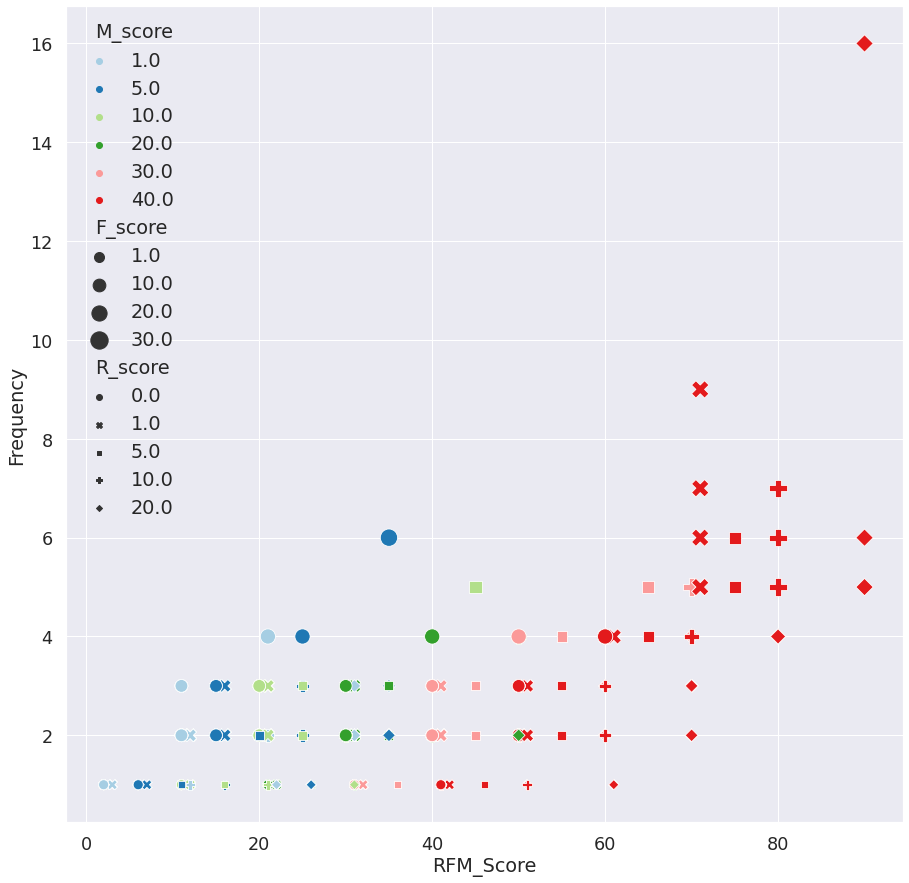

In [ ]:
#plot RFM_score
fig=plt.figure(figsize=(15,15))
sns.set(font_scale=1.6)
sns.scatterplot(data=dr_rfm,
                x='RFM_Score',
                y='Frequency',
                hue='M_score',
                size="F_score",
                style='R_score',
                sizes=(100, 300),
                palette='Paired',
                )

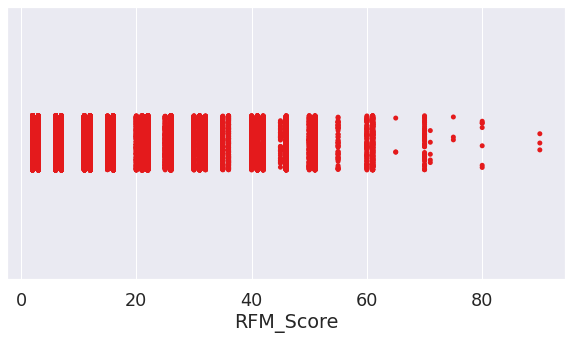

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.set(font_scale=1.6) 

ax = sns.stripplot(x="RFM_Score", data=dr_rfm,palette='Set1')

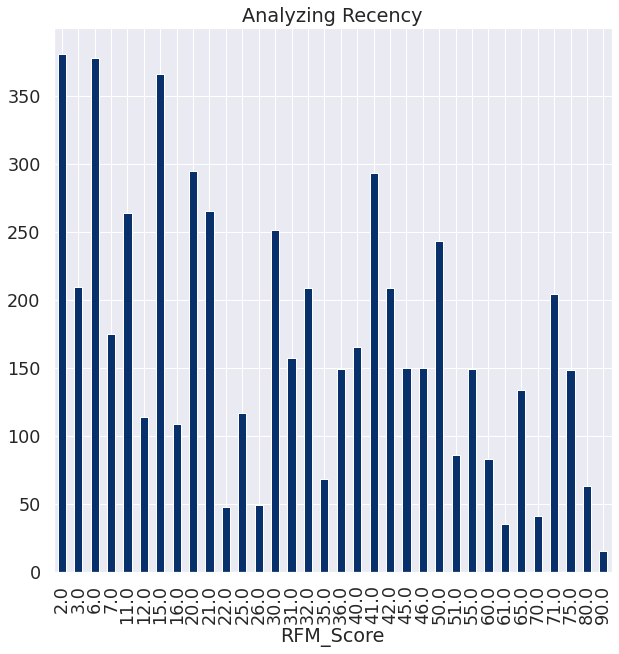

In [ ]:
# analyzing Recency /RFM_score
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Analyzing Recency')
dr_rfm.groupby('RFM_Score')['Recency'].mean().plot(kind='bar', colormap='Blues_r');


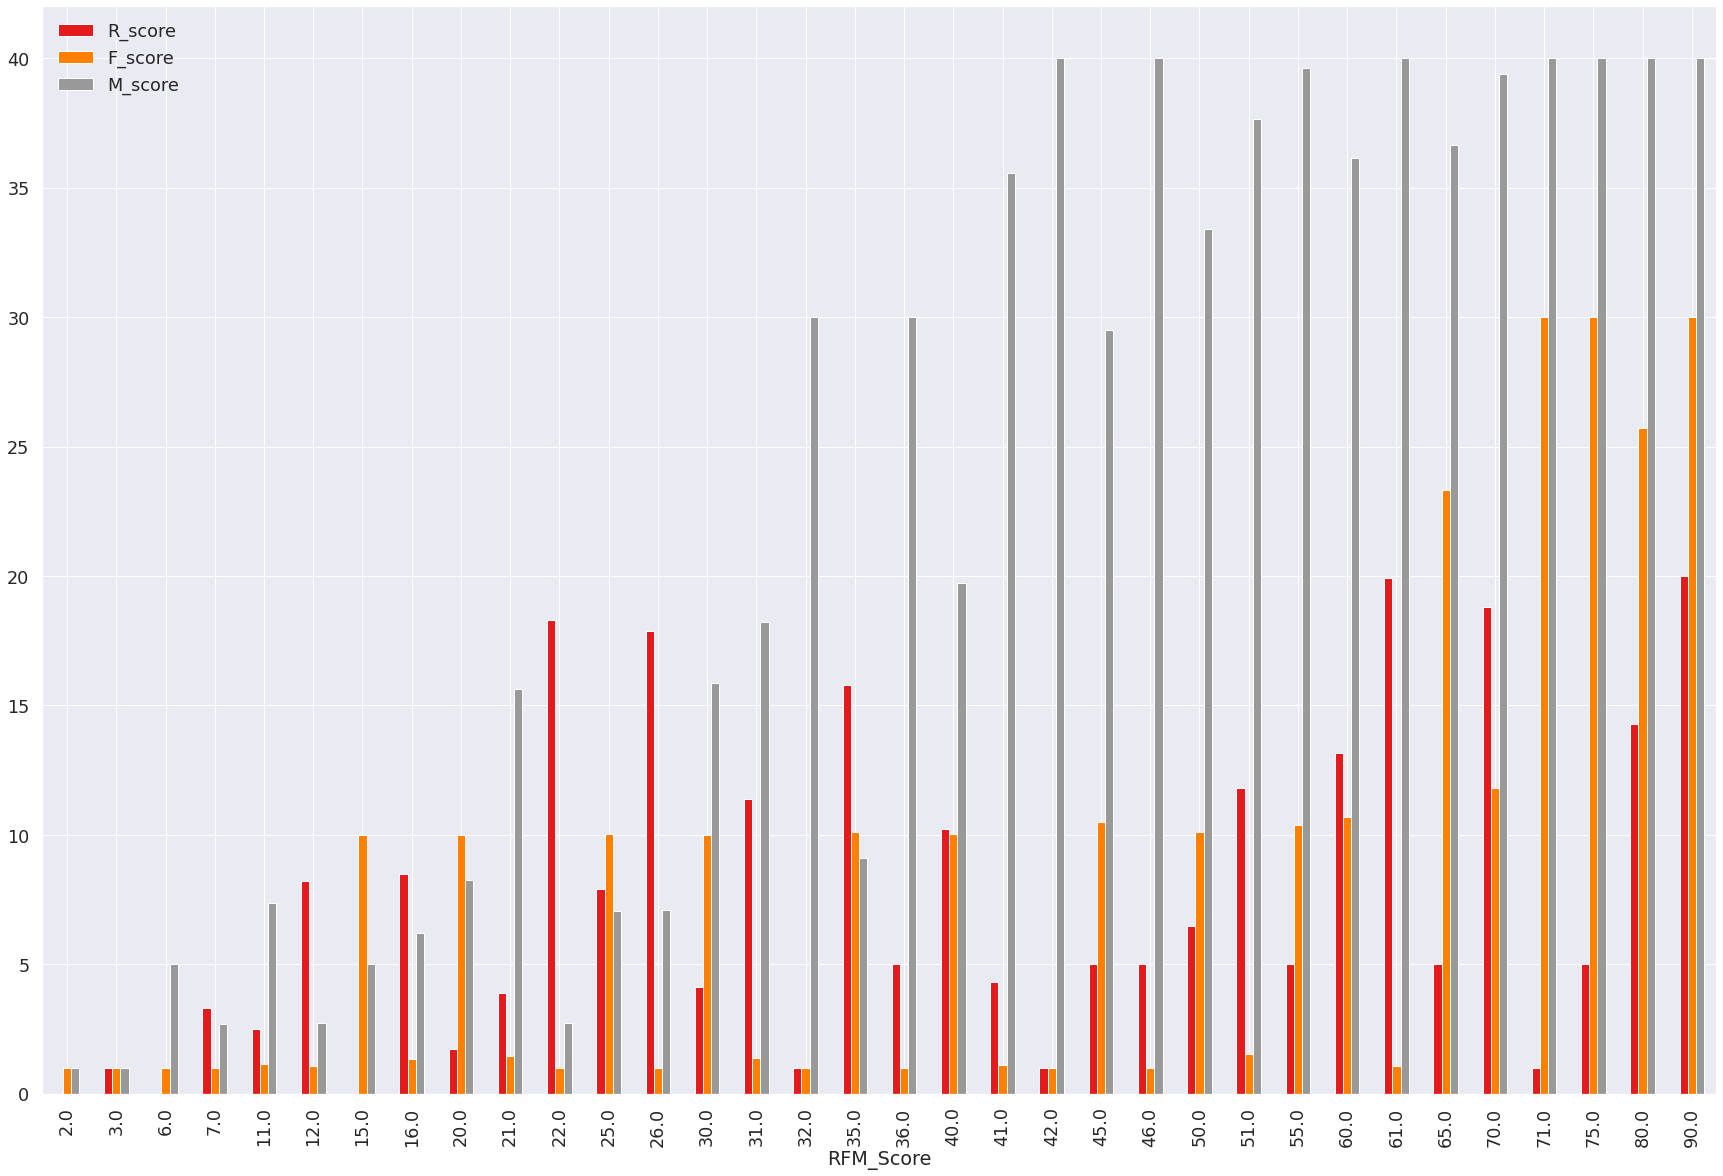

In [ ]:
dr_rfm.groupby('RFM_Score')[['R_score',
                             'F_score',
                             'M_score']].mean().plot(kind='bar',
                                                     colormap='Set1',
                                                     figsize=(30,20))


on veut isoler quelques client qui sont des clients Haut/VIP à traiter à part, ce sont des clients:
-  fidèles ; achètent au moins 5 fois
- dépensiers: panier moyen elevé  

Ces clients on les séparent des autres clients pour la segmentation 

Les VIP à traiter à part qui ont:
- un RFM_score >80 
- un panier moyen élevé

#2-Préprocessing

In [ ]:
def feature_engineering(df):

  # we create a variable that computes the purchase rate per day

  #percentage of purchase by age group  
  df['Frequency_age']=df['Frequency']/(df['age'])*100 

  #replace the value 0 by 1
  df.product_weight_g_mean = np.where(df.product_weight_g_mean == 0,
                                      1,
                                      df.product_weight_g_mean)
  df.payment_installments_sum = np.where(df.payment_installments_sum == 0,
                                         1,
                                         df.payment_installments_sum)
  df.finish_order=df.finish_order+1
  df.len_review_mean_=df.len_review_mean_+1

  # we create density of product 
  df['desity']=df['product_weight_g_mean']/(df['Volume_product_mean'])

  # We create a binary variable of categories
  df['catg']=df['catg_fashion']+df['catg_fashion']+\
                      df['catg_hobies']+df['catg_home']+\
                      df['catg_pro']+df['catg_tech']

  # We create a binary variable of payment_type
  df['nbr_payment_type']=df['payment_type_boleto']+df['payment_type_credit_card']+\
                         df['payment_type_debit_card']+df['payment_type_voucher']
  df.catg = np.where(df.catg == 0, 1, df.catg)
  df['review_message_len']=df.len_review_mean_ / df.review_score_mean
  return df

#apply feature_engineering functon on dataframe
df_client=feature_engineering(df_client_Olist)

In [ ]:
df_client.shape

(95415, 47)

vérification de la transforation pour la normalisation des variables

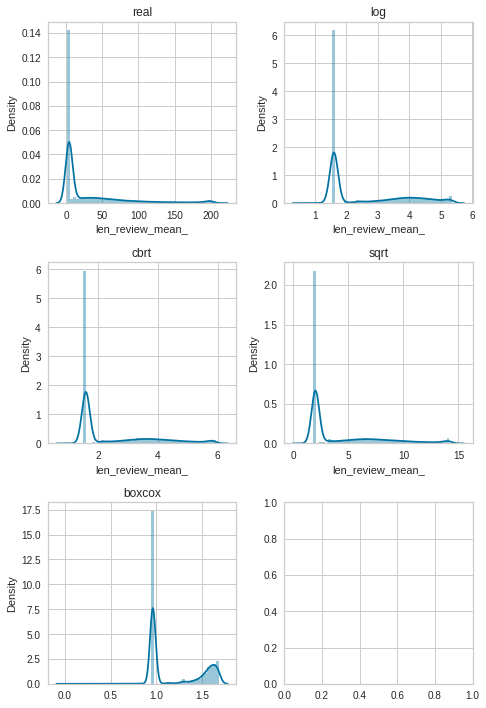

real: 2.01
log: 0.77
cubique: 1.08
racine carré: 1.28
boxcox: 0.4870803377385802


In [ ]:
analyze_skewness(df_client,'len_review_mean_')

Boxcox est le meilleur transformeur pour nos variables

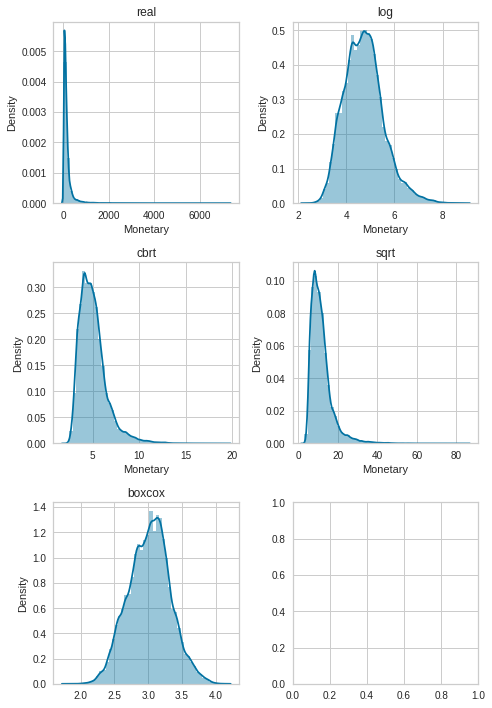

real: 7.08
log: 0.51
cubique: 1.63
racine carré: 2.44
boxcox: 0.006488105707049039


In [ ]:
analyze_skewness(df_client,'Monetary')

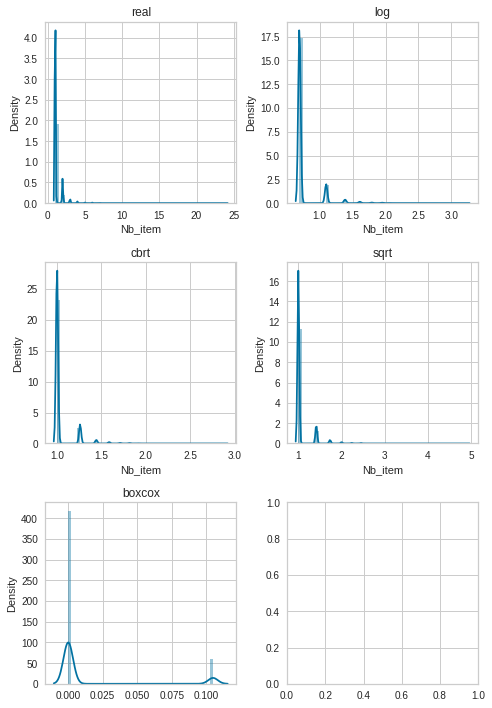

real: 7.34
log: 3.08
cubique: 3.67
racine carré: 4.14
boxcox: 2.2779626841018064


In [ ]:
analyze_skewness(df_client,'Nb_item')

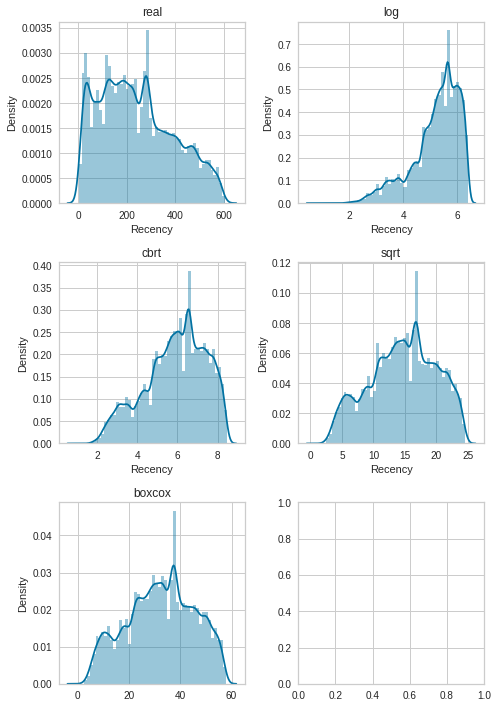

real: 0.41
log: -1.09
cubique: -0.47
racine carré: -0.21
boxcox: -0.14928201320203002


In [ ]:
analyze_skewness(df_client,'Recency')

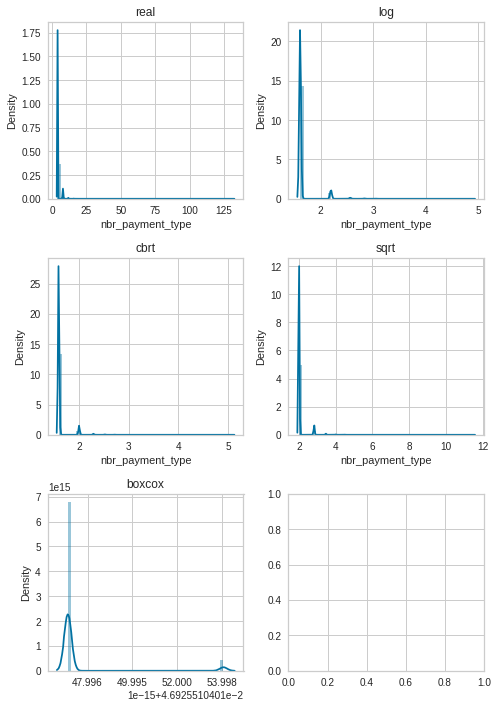

real: 19.64
log: 5.03
cubique: 6.45
racine carré: 7.84
boxcox: 0


In [ ]:
analyze_skewness(df_client,'nbr_payment_type')

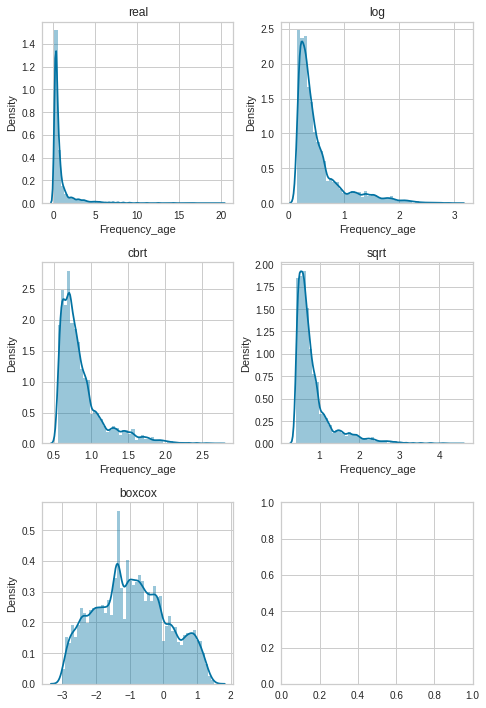

real: 4.48
log: 1.08
cubique: 1.89
racine carré: 2.39
boxcox: 0.14129830599247728


In [ ]:
analyze_skewness(df_client,'Frequency_age')

#3- Modélisation: Kmeans

On teste plusieurs types de standirsation pour voir lequelle donne un nombre de cluster bien definie

In [ ]:
#feature selection
RFM=['Recency','Frequency_age','Monetary','age',
     'payment_installments_sum','review_score_mean',
     'len_review_mean_','Nb_item']
data_rfm=df_client[RFM]
# Scale the features
data_scaled_minmax,data_scaled_Standard,data_scaled_Quantile=scaled(data_rfm)

Pour utiliser le modèle K-means, nous devons savoir combien de clusters se trouvent dans l'ensemble de données.Nous utiliserons la méthode du coude, le score des silhouette et le diagramme de silhouette comme indices supplémentaires.

**Méthode du coude:Sum_of_squared_distances**
La méthode du coude est utilisée pour déterminer le nombre correct de clusters dans un ensemble de données. Il fonctionne en traçant les valeurs croissantes de K par rapport à l'erreur totale obtenue lors de l'utilisation de ce K.

`%Variance=(Variance entre les groupes)/variance totale`

Le but est de trouver le k qui pour chaque cluster n'augmentera pas significativement la variance

### 3-1 Nombre de cluster

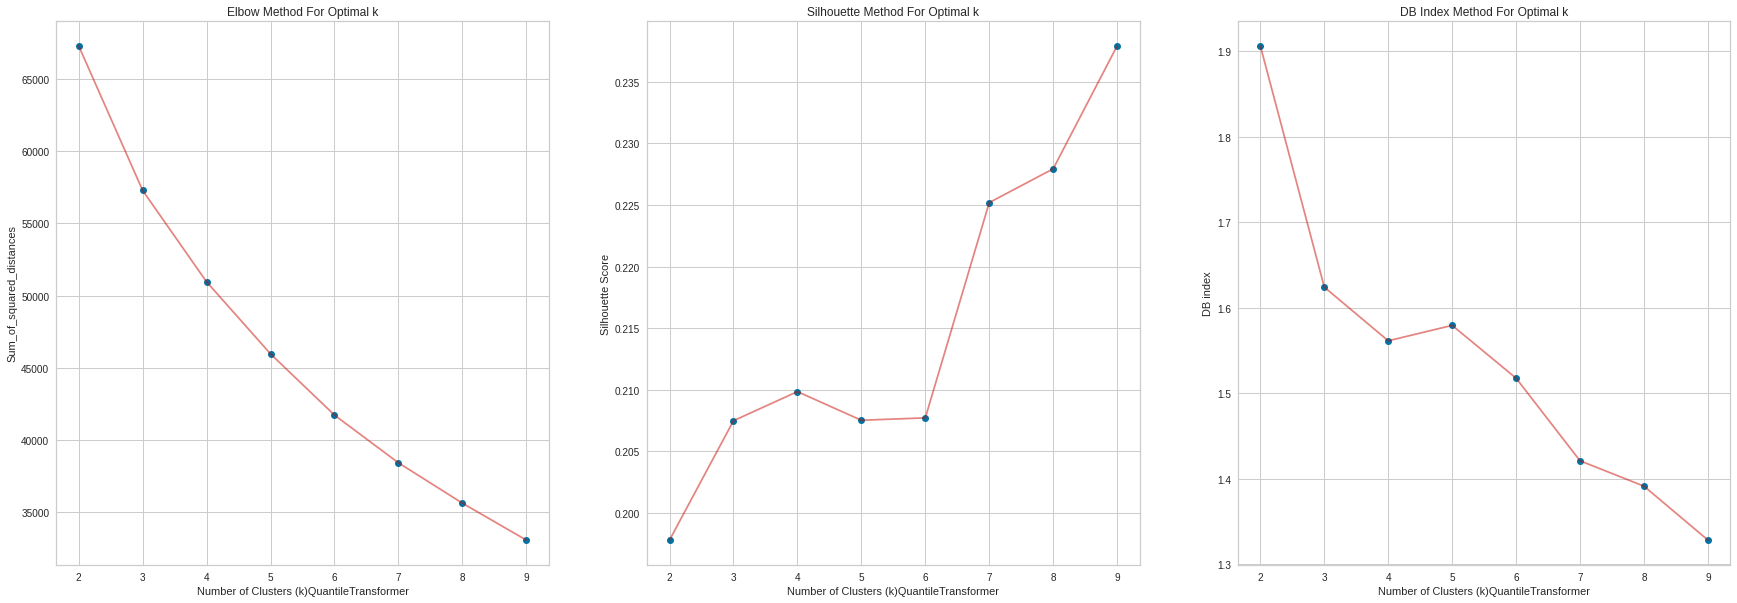

In [ ]:
#Number of clester with QuantileTransformer
k_number(data_scaled_Quantile,'QuantileTransformer')

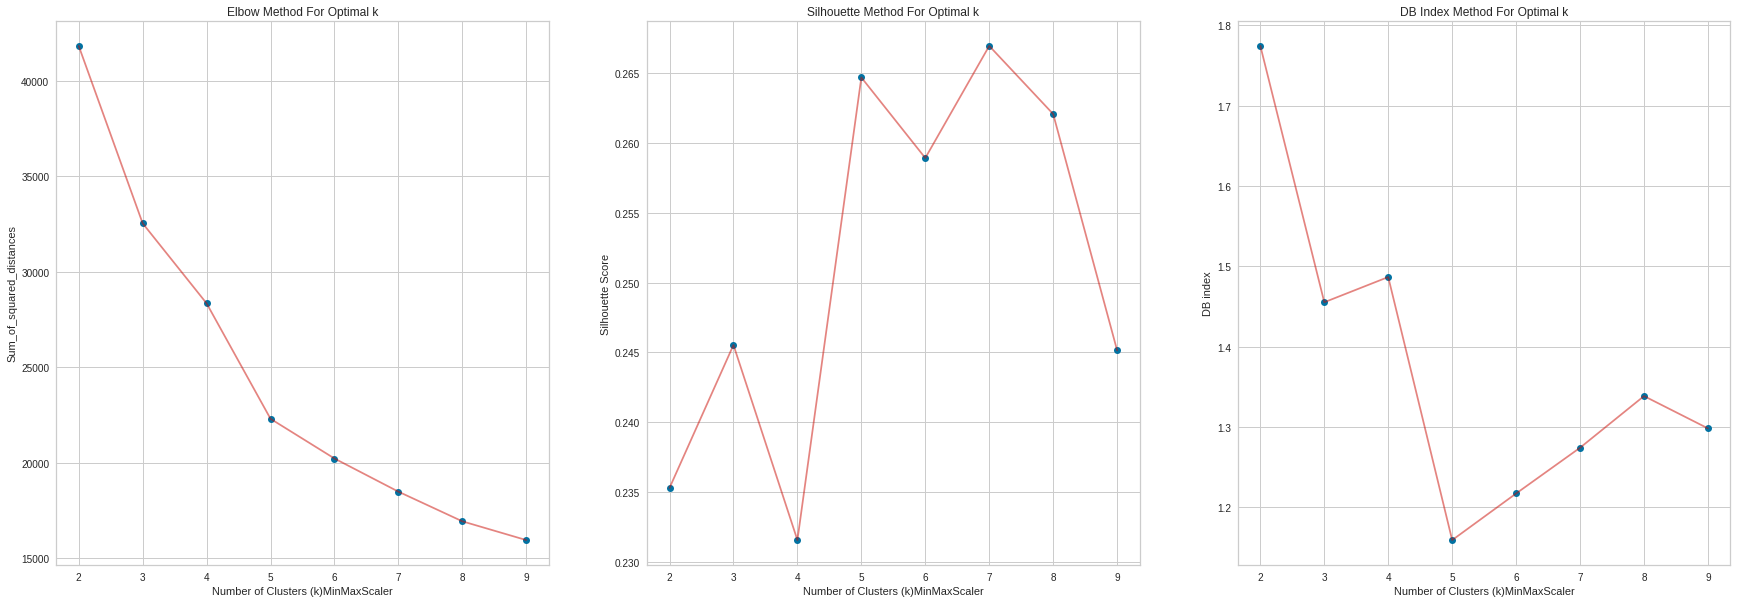

In [ ]:
#Number of clester with MinMaxScaler
k_number(data_scaled_minmax,'MinMaxScaler')

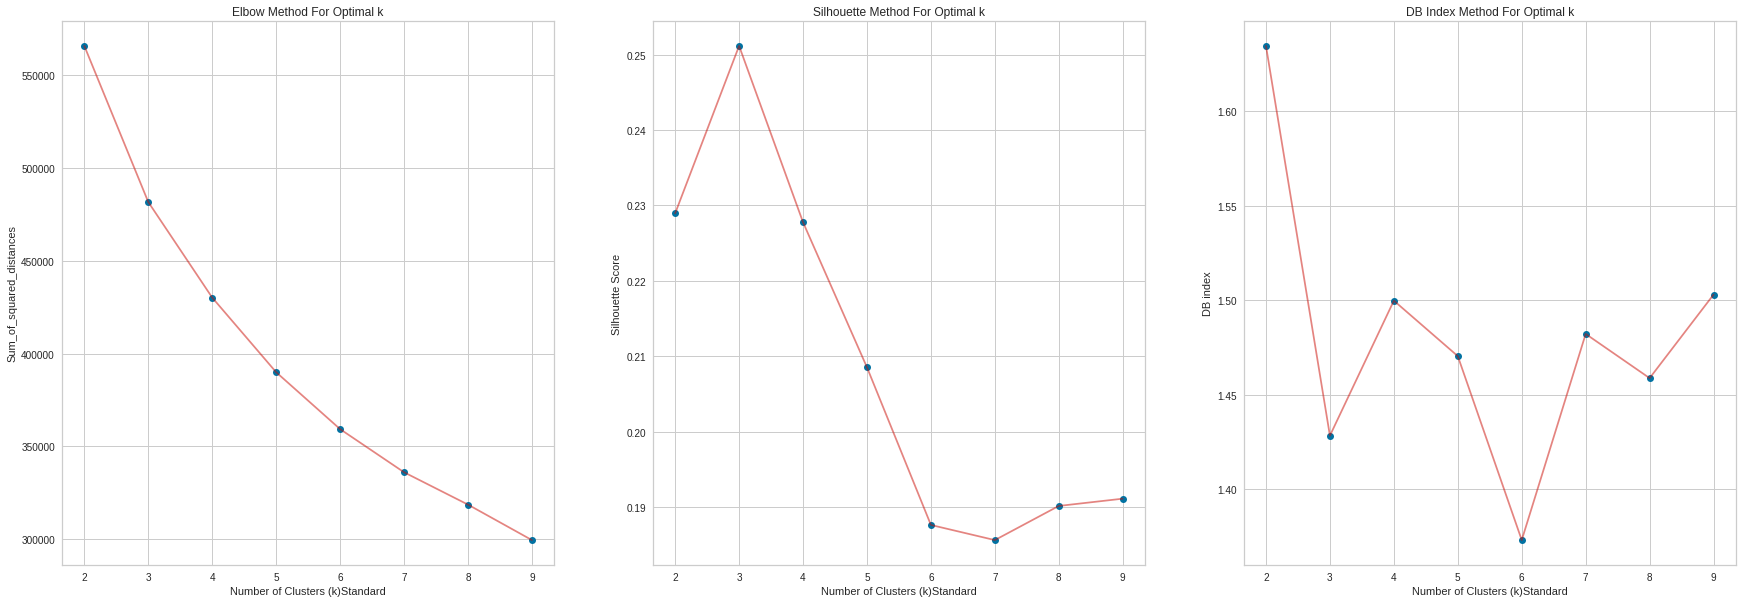

In [ ]:
#Number of clester with StandardScaler
k_number(data_scaled_Standard,'Standard')

Donc on choisi comme standar c'est le MinMaxTransformer et le nombre de cluster est 5

### 3-2 Stabilité

pour la stabilité on choisit les critère
- ARI stabilité des clusters sur plusieurs itération
- l'homogénéité  des clusters
- stabilité dans le temps

In [ ]:
#model
km = KMeans(n_clusters=5,init='random', n_init = 10 ,max_iter=100, 
                          tol=0.0001,  random_state= 20  , algorithm='auto' )

#compute scores 
score_minmax,Sc_minmax=stability(data_scaled_minmax,km, nb_itr=6)
score_Standard,Sc_Standard=stability(data_scaled_Standard,km, nb_itr=6)
score_Quantile,Sc_Quantile=stability(data_scaled_Quantile,km, nb_itr=6)

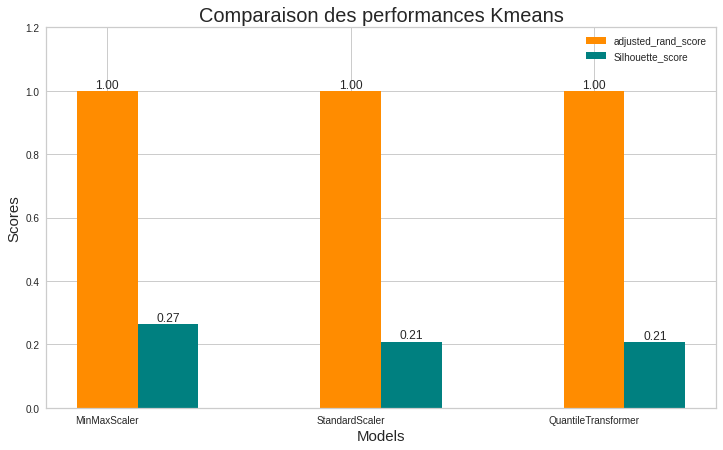

In [ ]:

#display scores of  each Scaler
columns_train=['adjusted_rand_score','Silhouette_score']
index = ['MinMaxScaler',"StandardScaler","QuantileTransformer"]
tab_score=pd.DataFrame([[score_minmax,Sc_minmax],
                        [score_Standard,Sc_Standard],
                        [score_Quantile,Sc_Quantile],
                      ],index = index,columns=columns_train ).round(3)

#plot bar each Scaler 
barWidth = 0.25# the width of the bars

r1 = np.arange(len(tab_score))
r2 = [x + barWidth for x in r1]
fig, ax = plt.subplots(figsize=(12,7))

rec1=ax.bar(r1,
            tab_score['adjusted_rand_score'],
            color='darkorange',
            width=barWidth,
            label='adjusted_rand_score')
rec2=ax.bar(r2,
            tab_score['Silhouette_score'],
            color='teal',
            width=barWidth,
            label='Silhouette_score')

for rect in rec1 :
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
            '{:1.2f}'.format(height),
            ha='center', va='bottom')
for rect in rec2 :
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
            '{:1.2f}'.format(height),
            ha='center', va='bottom')
# add some text for labels, title and axes ticks
ax.set_title('Comparaison des performances Kmeans', fontsize = 20)
ax.set_xlabel('Models', fontsize = 15)
ax.set_ylabel('Scores', fontsize = 15)
ax.set_ylim(top=1.2)
plt.xticks(r1, tab_score.index)
ax.legend()
plt.show()

Donc le modèle le plus stable est un kmeans sur les données standardisées avec MinMaxTransformer.

### 3-3 Visualation 

Pour bien visualiser nos clusters on utilise un algorithme de réduction de la dimensionnalité est la visualisation d'un ensemble de données. Pour ce faire, nous utilisons PCA, t-SNE, UMAP et MDS pour projeter nos données dans l'espace 2D.

In [ ]:
from sklearn.manifold import TSNE, Isomap, MDS
#Kmeans hyperparameters 
km = KMeans(n_clusters=5,
            init='random',
            n_init = 10 ,
            max_iter=100, 
            tol=0.0001,
            random_state= 20,
            algorithm='auto' )
#Random row selection on dataframe
data_scaled_sample=data_scaled_minmax.sample(15000)
data_scaled_MDS=data_scaled_minmax.sample(5000)
#fiting the model km
km.fit(data_scaled_sample)
#labels for  model
label_ = km.labels_

km.fit(data_scaled_MDS)
#labels for MDS model
label_mds = km.labels_

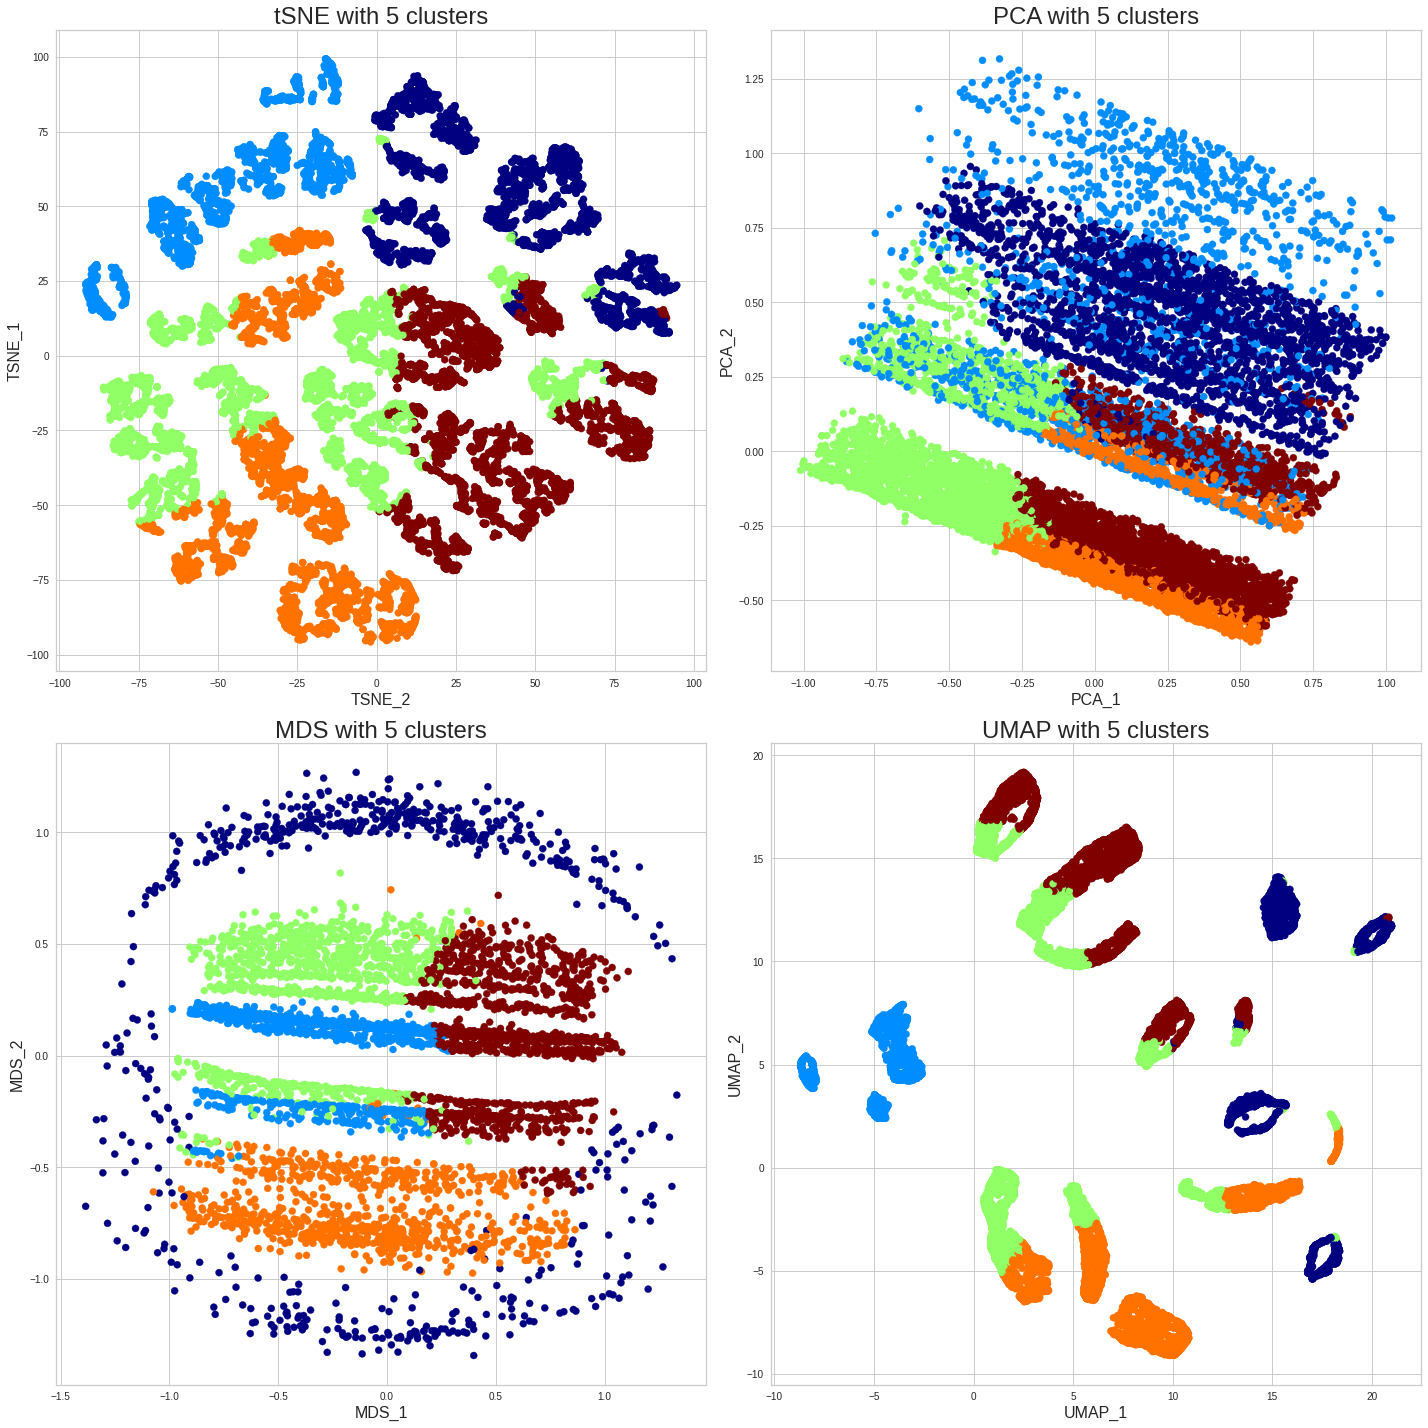

In [ ]:
# Visualize with : ACP, TSNE, Isomap ,UMAP,MDS
#We first use PCA , TSNE, Isomap ,UMAP,MDS to reduce the dataset to two dimensions by setting n_components=2.
# Then we'll visualize the features by plotting the two components against each other
from umap import UMAP
from sklearn.manifold import TSNE, Isomap, MDS

#color
cmap = plt.get_cmap('jet', 20)
cmap.set_under('gray')
fig, ax = plt.subplots(2, 2, figsize=(20,20))

tsne_ = TSNE(n_components = 2,
             random_state=42,
             init='pca',# reduce to  PCA components, before t-SNE
             ).fit_transform(data_scaled_sample)
ax[0,0].scatter(tsne_[:, 0], tsne_[:, 1], c=label_, s=50, cmap=cmap)
ax[0,0].set_xlabel('TSNE_2', fontsize=16)
ax[0,0].set_ylabel('TSNE_1', fontsize=16)
ax[0,0].set_title('tSNE with 5 clusters', fontsize=24)
ax[0,0].grid(True)

#We first use PCA to reduce the dataset to two dimensions by setting n_components=2.
# Then we'll visualize the dataset by plotting the two components against each other
pca_ = PCA(n_components = 2).fit_transform(data_scaled_sample)
ax[0,1].scatter(pca_[:, 0], pca_[:, 1], c=label_, s=50, cmap=cmap)
ax[0,1].set_xlabel('PCA_1', fontsize=16)
ax[0,1].set_ylabel('PCA_2', fontsize=16)
ax[0,1].set_title('PCA with 5 clusters', fontsize=24)
ax[0,1].grid(True)

##We first use MDS to reduce the dataset to two dimensions by setting n_components=2.
# Then we'll visualize the dataset by plotting the two components against each other
mds = MDS(n_components = 2,
          random_state=42).fit_transform(data_scaled_MDS)
ax[1,0].scatter(mds[:, 0], mds[:, 1], c=label_mds, s=50, cmap=cmap)
ax[1,0].set_xlabel('MDS_1', fontsize=16)
ax[1,0].set_ylabel('MDS_2', fontsize=16)
ax[1,0].set_title('MDS with 5 clusters', fontsize=24)
ax[1,0].grid(True)

#Uniform Manifold Approximation and Projection (UMAP)
#The UMAP hyperparameter that need to be tuned to get good results:n_neighbors
umap_ = UMAP(n_neighbors=50
             ,n_components = 2,
             random_state=100).fit_transform(data_scaled_sample)
ax[1,1].scatter(umap_[:, 0], umap_[:, 1], c=label_, s=50, cmap=cmap)
ax[1,1].set_xlabel('UMAP_1', fontsize=16)
ax[1,1].set_ylabel('UMAP_2', fontsize=16)
ax[1,1].set_title('UMAP with 5 clusters', fontsize=24)
ax[1,1].grid(True)

plt.tight_layout()
plt.show()

**Sélection du nombre de clusters avec analyse de silhouette sur le clustering KMeans**: L'analyse de silhouette affiche la distance de séparation entre les clusters ainsi que la taille de chaqu'un pour etudier l'homogénéité . 

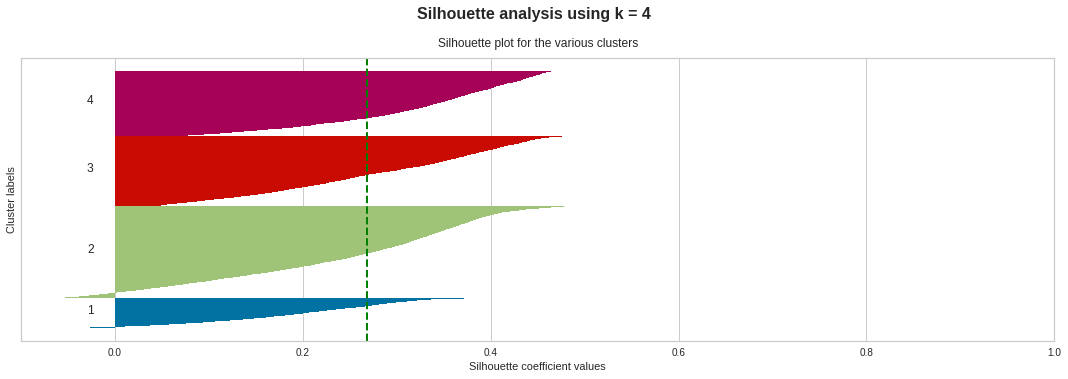

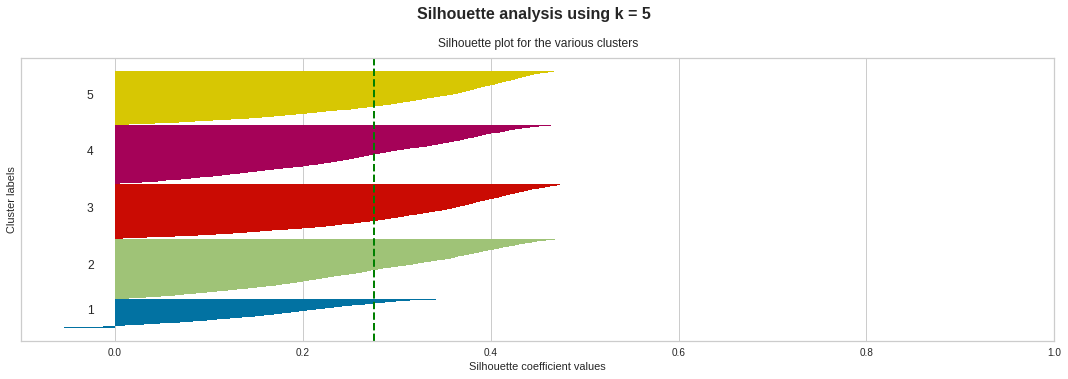

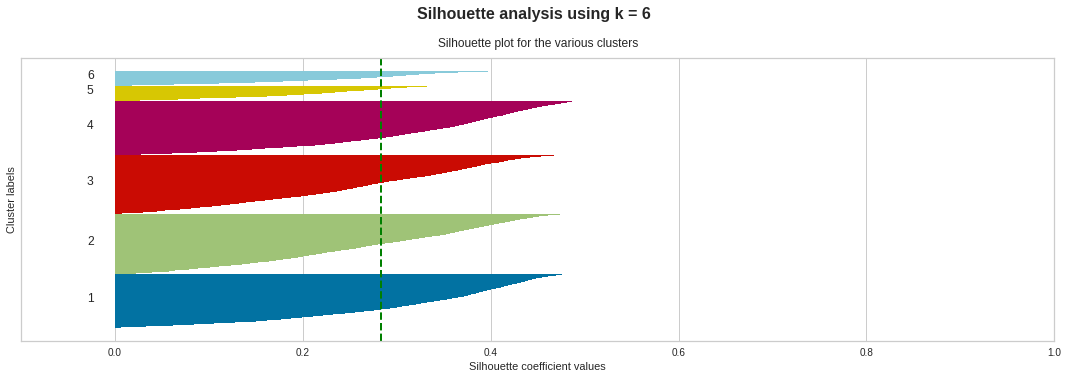

In [ ]:
X=data_scaled_sample.copy()
for i, k in enumerate([4,5,6]):
    fig, ax1 = plt.subplots(1, 1,figsize=(15,5))
    
    # Run the Kmeans algorithm
    km=KMeans(n_clusters=k,
              init='random',
              n_init = 10 ,
              max_iter=100, 
              tol=0.0001,
              random_state= 20  ,
              algorithm='auto')
    label = km.fit_predict(X)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X, label)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(label)):
        cluster_silhouette_vals = silhouette_vals[label == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower,y_upper),
                 cluster_silhouette_vals,
                 edgecolor='none',
                 height=1)
        ax1.text(-0.03,
                 (y_lower + y_upper) / 2, 
                 str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score,
                linestyle='--',
                linewidth=2,
                color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    

    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

**PCA visualisation**

In [ ]:
X_pca=data_scaled_minmax.sample(20000, random_state=50)
pca = PCA(n_components=4, random_state=100)
pca_results = pca.fit_transform(X_pca)
print(pca.explained_variance_ratio_.sum())
pca.explained_variance_ratio_.cumsum()

0.9207759074549915


array([0.2956396 , 0.56085718, 0.76747404, 0.92077591])

In [ ]:
df_scree = pd.DataFrame({'Component': ['1','2','3','4'],
                         'Indiv':pca.explained_variance_ratio_})
df_scree['cum_sum'] = df_scree['Indiv'].cumsum()
df_scree

Component     Indiv   cum_sum
0         1  0.295640  0.295640
1         2  0.265218  0.560857
2         3  0.206617  0.767474
3         4  0.153302  0.920776

In [ ]:
df_pca = pd.DataFrame(pca_results)
df_pca.columns = ['PC1', 'PC2','PC3','PC4']
km.fit(X_pca)
df_pca['cluster'] = km.labels_
df_pca['cluster'] =[mapping[i] for i in df_pca['cluster']]

df_pca.head()

PC1       PC2       PC3       PC4  cluster
0  0.421435  0.441292 -0.338763 -0.143726  Cient 3
1 -0.108613  0.038124 -0.322575  0.159559  Cient 2
2  0.139498 -0.069076 -0.347704  0.190558  Cient 2
3 -0.162073  0.589799 -0.033847 -0.462980  Cient 3
4 -0.268438  0.182564 -0.319326  0.132509  Cient 4

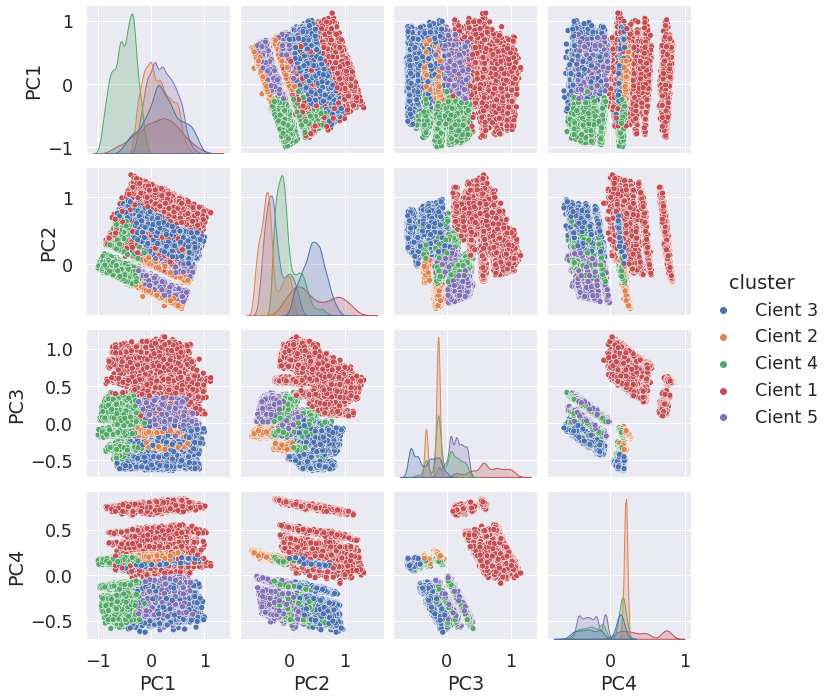

In [ ]:
g = sns.pairplot(df_pca, hue="cluster")
plt.show()

In [ ]:
import plotly.express as px
  
  
fig = px.scatter_3d(df_pca, x = 'PC1', 
                    y = 'PC2', 
                    z = 'PC3',
                    color = 'cluster')
  
fig.show()

### 3-4 Interprétation et analyse des clusters

Essayons maintenant d'interpréter les clusters selon leur comportement d'acaht,

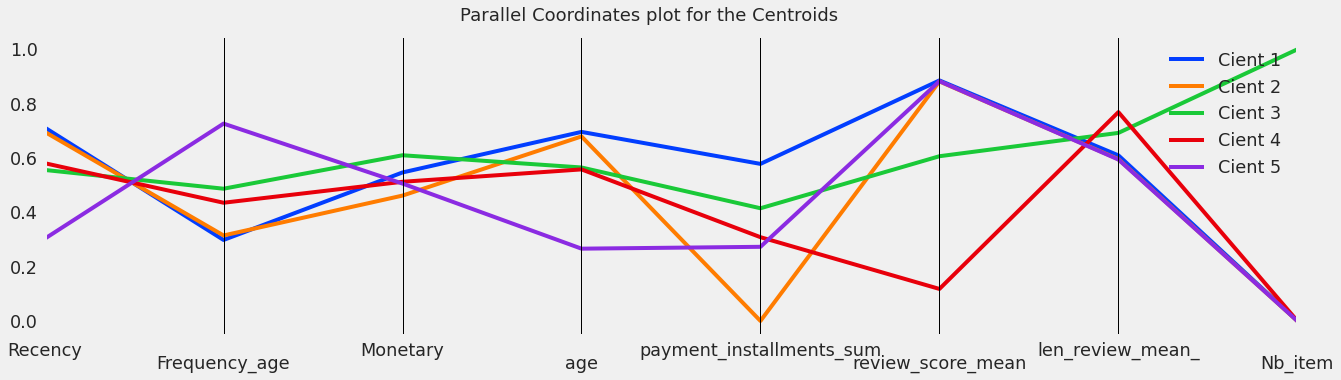

In [ ]:
#plot the parallel coordiates for the centroids 
n_cluster=5
km=KMeans(n_clusters=n_cluster,init='random', n_init = 10 ,max_iter=100, 
                          tol=0.0001,  random_state= 20  , algorithm='auto')
X_td=data_scaled_minmax.copy()
#fit the model
km.fit(X_td)
#label
labels=km.labels_

centroids = pd.DataFrame(km.cluster_centers_,
                         columns=X_td.columns)
centroids['cluster'] = centroids.index
mapping = {0:'Cient 1', 1:'Cient 2', 2:'Cient 3', 3:'Cient 4', 4:'Cient 5'}
centroids['cluster'] =[mapping[i] for i in centroids['cluster']]
display_parallel_coordinates_centroids(centroids, n_cluster)

In [ ]:
#silhouette score
SS_total=silhouette_score(data_scaled_minmax,
                          labels,
                          metric='euclidean')

In [ ]:
SS_total

0.2647115873638425

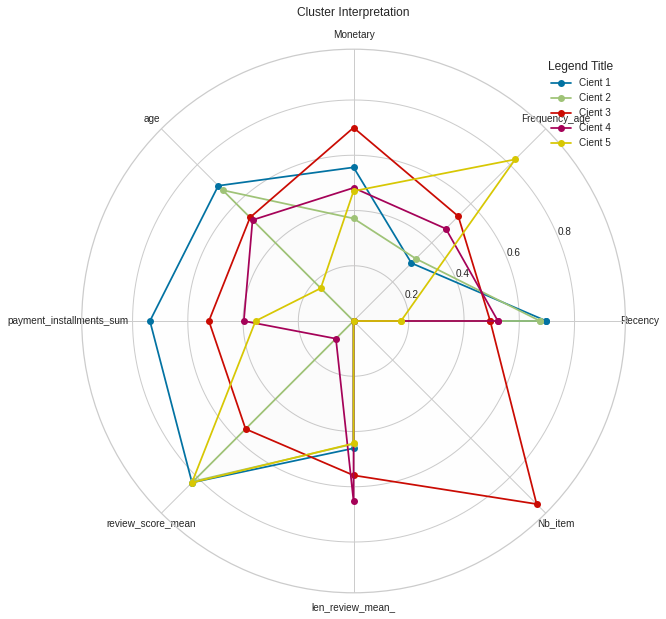

In [ ]:
#interpretation of clusters

fig =plt.figure(figsize=(10, 10))
X_std=data_scaled_Quantile.copy()
X_std['Cluster'] = labels
data_Cluster_Id  = X_std.groupby("Cluster").mean()
ax = fig.add_subplot(111, polar=True)
cols=data_Cluster_Id.columns
legends = []
for i in range(0,5):
    data = data_Cluster_Id.loc[i, cols].values
    angles=np.linspace(0, 2*np.pi, len(cols), endpoint=False)
    stats=np.concatenate((data,[data[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    ax.plot(angles, stats, "o-")
    ax.fill(angles, stats, alpha=0.0025)
    ax.set_thetagrids(angles * 180/np.pi, cols)
    legends.append(data_Cluster_Id.index[i])
legends =[mapping[i] for i in legends]
plt.title("Cluster Interpretation")
plt.legend(legends,              # List of the line objects
           loc="lower  left",        # Position of the legend
           borderaxespad=0.8,         # Add little spacing around the legend box
           title="Legend Title")      # Title for the legend)
plt.show()

In [ ]:
data_rfm["Cluster"] = km.labels_
data_rfm['Cluster'] =[mapping[i] for i in data_rfm['Cluster']]
data_rfm["Cluster"].value_counts()

Cient 5    24560
Cient 1    21667
Cient 2    19706
Cient 4    17363
Cient 3    11820
Name: Cluster, dtype: int64

In [ ]:
data_rfm.sample(2)

Recency  Frequency_age  Monetary  age  \
customer_unique_id                                                        
77f509d49be1483b97d55ca707075cc5      315       0.317460     37.00  315   
3f2fa5728dc7ec636fec3038c1b83f9f      389       0.257069    178.34  389   

                                  payment_installments_sum  review_score_mean  \
customer_unique_id                                                              
77f509d49be1483b97d55ca707075cc5                       1.0                4.0   
3f2fa5728dc7ec636fec3038c1b83f9f                       1.0                5.0   

                                  len_review_mean_  Nb_item  Cluster  
customer_unique_id                                                    
77f509d49be1483b97d55ca707075cc5               4.0      1.0  Cient 3  
3f2fa5728dc7ec636fec3038c1b83f9f              41.0      1.0  Cient 3

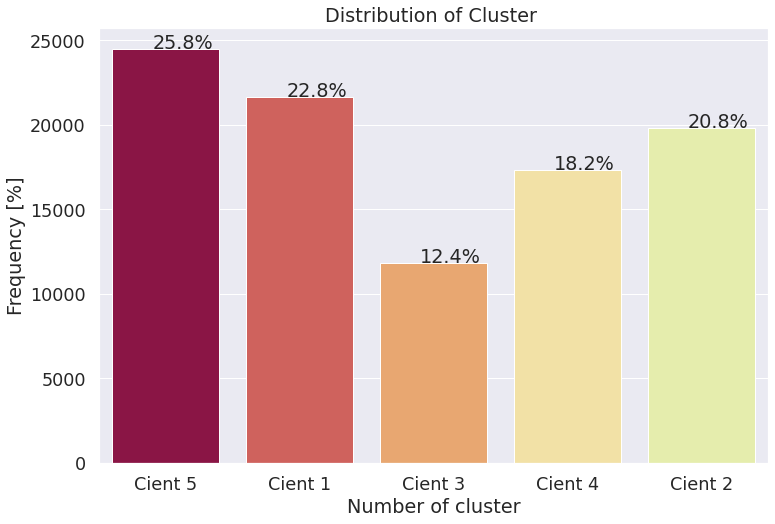

In [ ]:
#Distribution for features

data_rfm["Cluster"] = labels
data_rfm['Cluster'] =[mapping[i] for i in data_rfm['Cluster']]
data_rfm["Cluster"].value_counts()

total = len(data_rfm)*1.
plt.figure(figsize=(12,8))
sns.set(font_scale=1.6)  
ax = sns.countplot(x="Cluster", data=data_rfm,palette=colors)
plt.title('Distribution of Cluster ')
plt.xlabel('Number of cluster')
plt.ylabel('Frequency [%]')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total),
                                    (p.get_x()+0.3,
                                     p.get_height()+10))



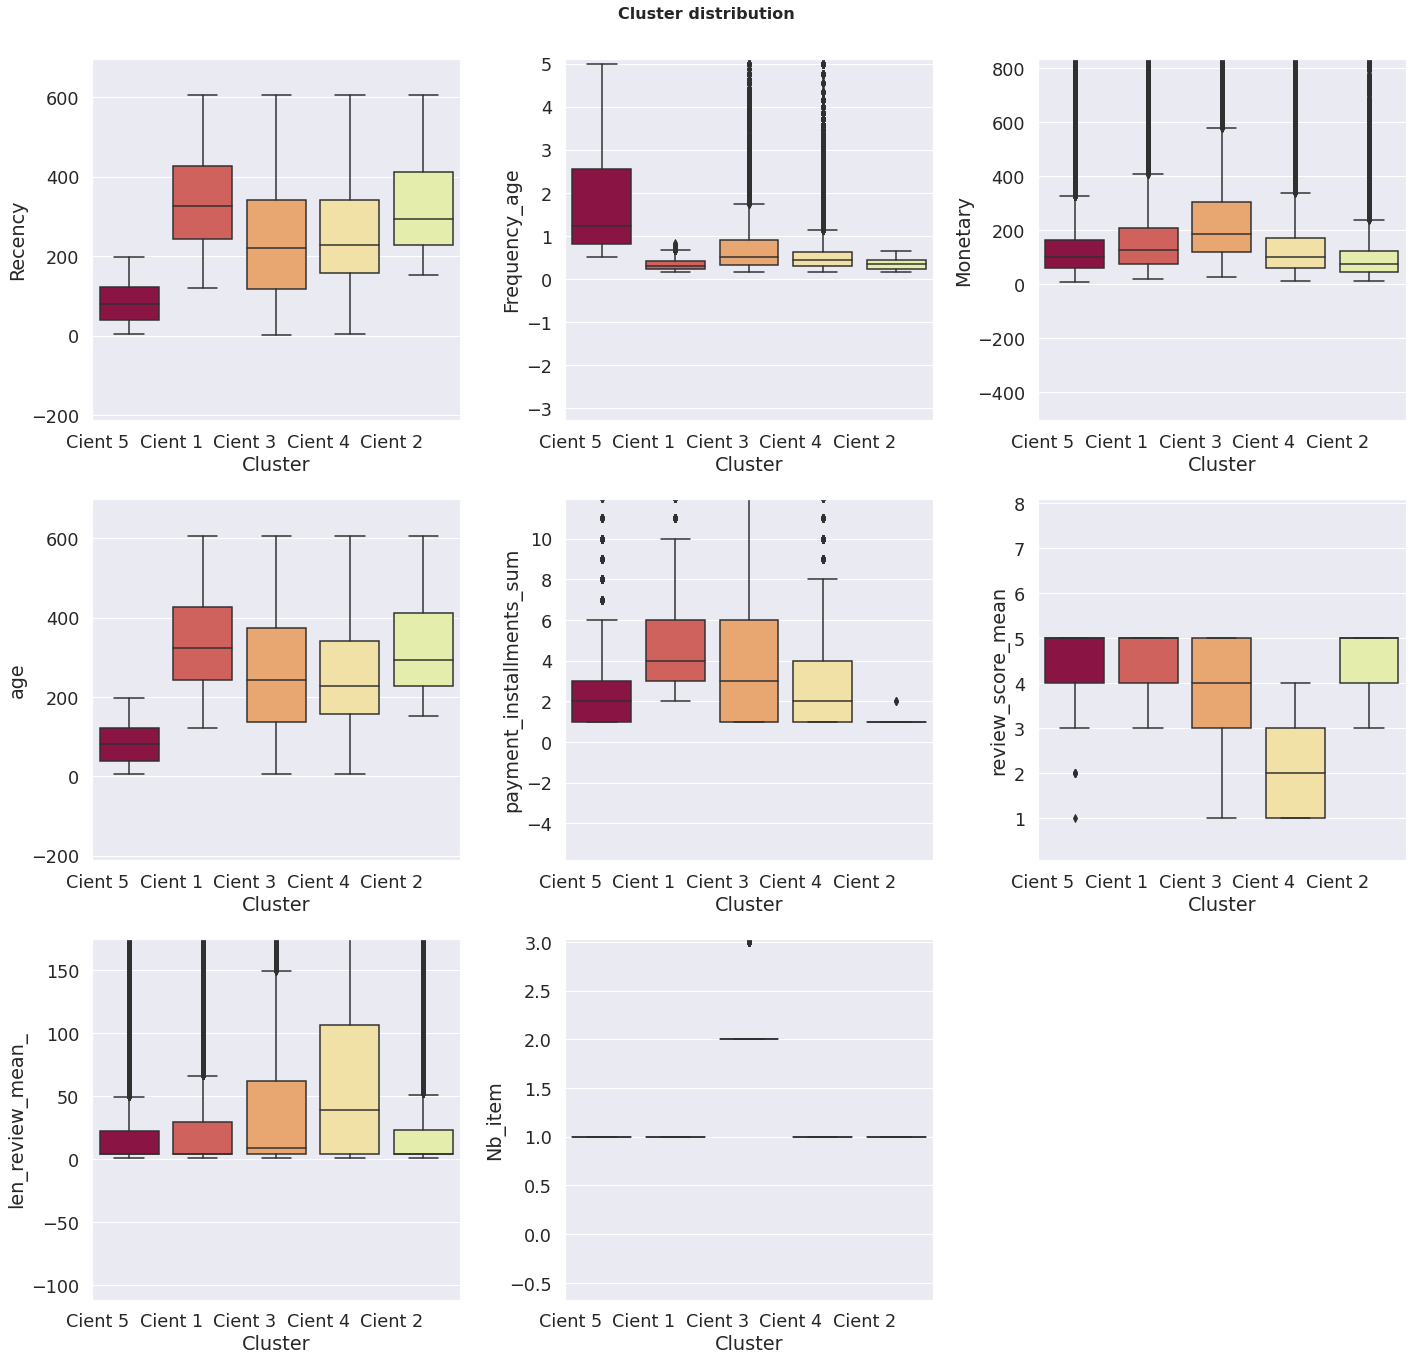

In [ ]:
# Plotting boxplots of each variables data for each cluster
fig = plt.figure(figsize=(20,20))
with sns.color_palette(colors):
    for i, c in enumerate(RFM,1):
        ax = fig.add_subplot(3,3,i)
        sns.boxplot(data=data_rfm, x='Cluster', y=c, ax=ax)
        min = data_rfm[c].mean()-3*data_rfm[c].std()
        max = data_rfm[c].mean()+3*data_rfm[c].std()
        plt.ylim(min,max)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [s[0:10]+'.' if len(s)>10 else s for s in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks( ha='right')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.suptitle('Cluster distribution', fontsize=16,
             fontweight='bold')

plt.show()

In [ ]:
RFM

['Recency',
 'Frequency_age',
 'Monetary',
 'age',
 'payment_installments_sum',
 'review_score_mean',
 'len_review_mean_',
 'Nb_item']

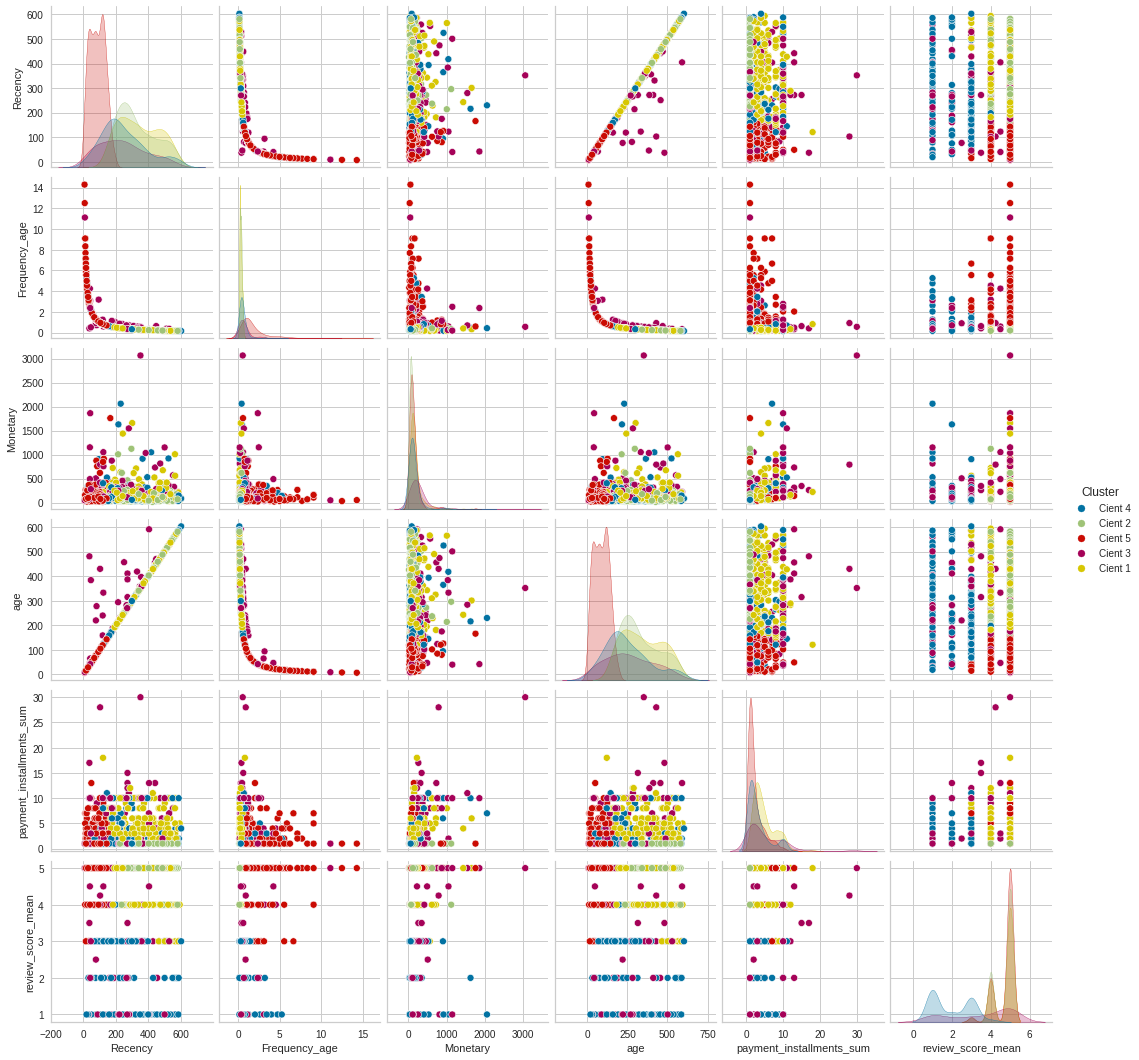

In [ ]:
# pairplot for features to serach correlation
#fig = plt.figure(figsize=(20,20))
X=data_rfm[['Recency','Frequency_age','Monetary','age',
            'payment_installments_sum','review_score_mean',
            'Cluster']].sample(1000, random_state=50)
g = sns.pairplot(X, hue="Cluster")
plt.show()

### 3-5 Stabilité des clusters dans le temps

pour la stabilité dans le temps on a choisi de voir le % et le silhouette_score chaque trimestre

In [ ]:
RFM

['Recency',
 'Frequency_age',
 'Monetary',
 'age',
 'payment_installments_sum',
 'review_score_min',
 'Nb_item',
 'desity']

préparer les datas dans chaque periode

In [ ]:
#Kmeans on Trimester 1
df_Olist_T1=df_Olist_T1[~df_Olist_T1.index.isin(VIP)]
#Kmeans on Trimester 2
df_Olist_T2=df_Olist_T2[~df_Olist_T2.index.isin(VIP)]
#Kmeans on Trimester 3
df_Olist_T3=df_Olist_T3[~df_Olist_T3.index.isin(VIP)]
#Kmeans on Trimester 4
df_Olist_T4=df_Olist[~df_Olist.index.isin(VIP)]

df_client=df_client.copy()

In [ ]:
VIP

Index(['0a0a92112bd4c708ca5fde585afaa872', '394ac4de8f3acb14253c177f0e15bc58',
       '8d50f5eadf50201ccdcedfb9e2ac8455', 'da122df9eeddfedc1dc1f5349a1a690c',
       'dc813062e0fc23409cd255f7f53c7074'],
      dtype='object', name='customer_unique_id')

In [ ]:
df_client.shape

(95116, 48)

In [ ]:
df_Olist_T4.shape

(95116, 41)

Data T1


silhouette_score for kmeans: 0.2280250462489887


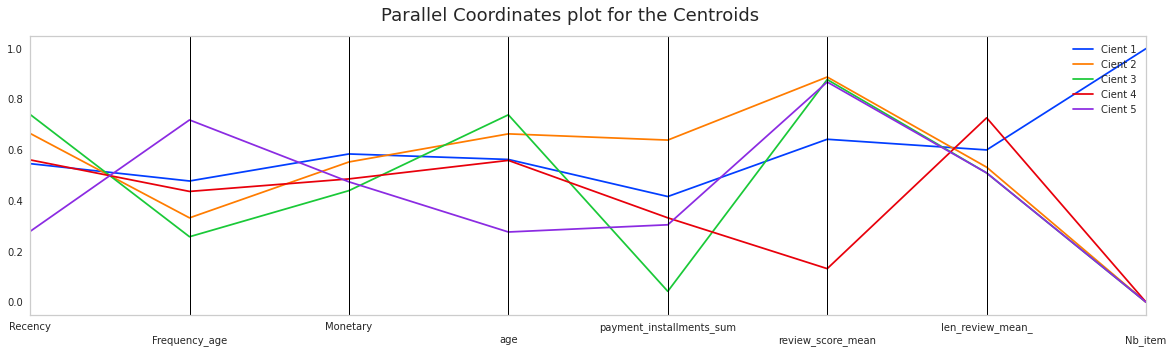

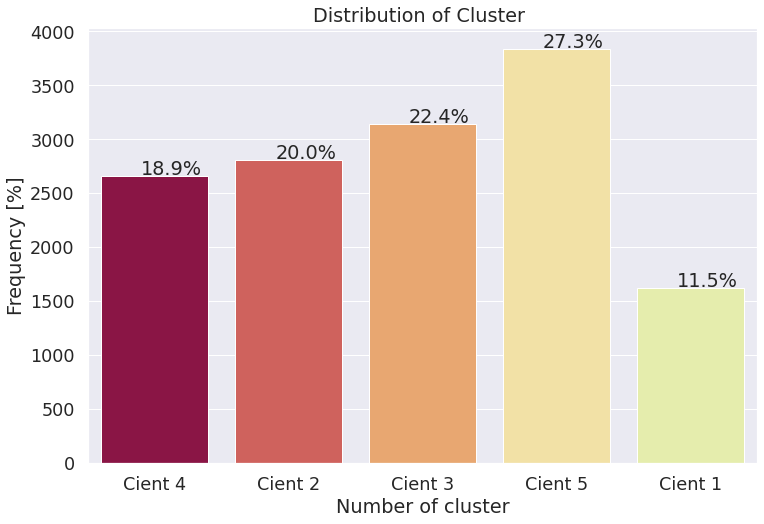

In [ ]:
#Interpretation 
label_T1,data_rfm_T1,SS_T1,arie_T1=data_clustering_time(df_Olist_T1,5,mapping)

silhouette_score for kmeans: 0.24043189545220045


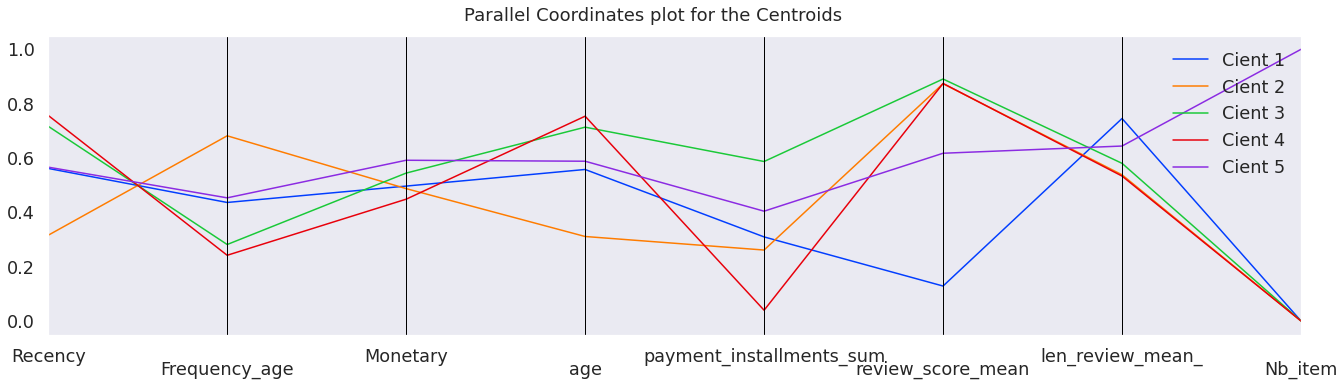

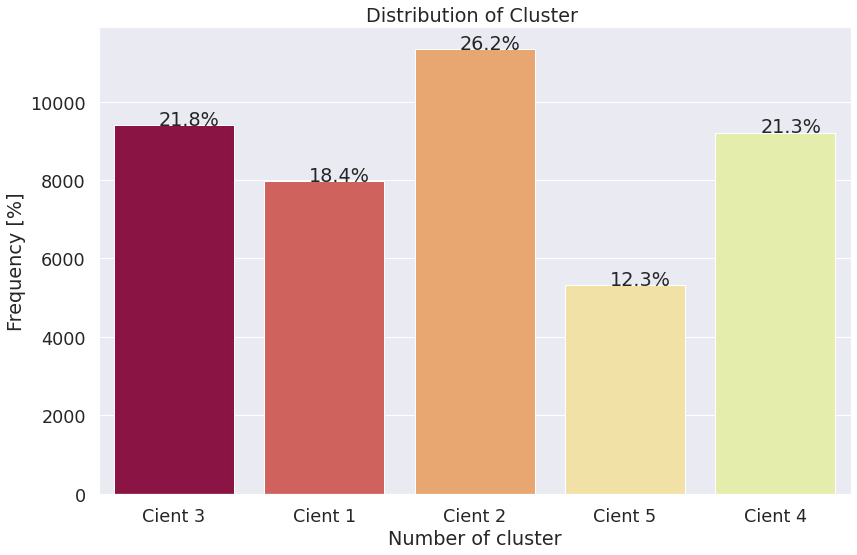

In [ ]:
#Interpretation
mapping = {0:'Cient 1', 1:'Cient 2', 2:'Cient 3', 3:'Cient 4', 4:'Cient 5'}

label_T2,data_rfm_T2,SS_T2,ari_T2=data_clustering_time(df_Olist_T2,5,mapping)

silhouette_score for kmeans: 0.24545012222035403


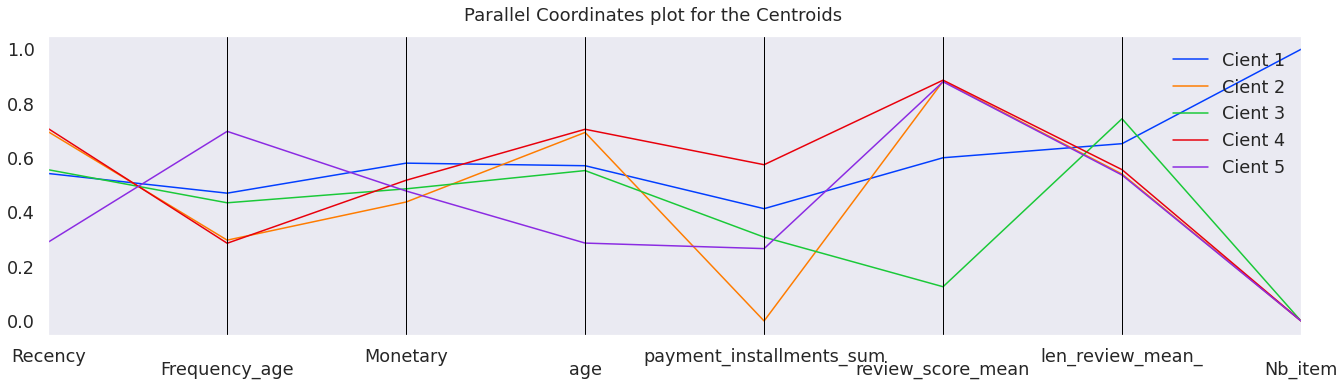

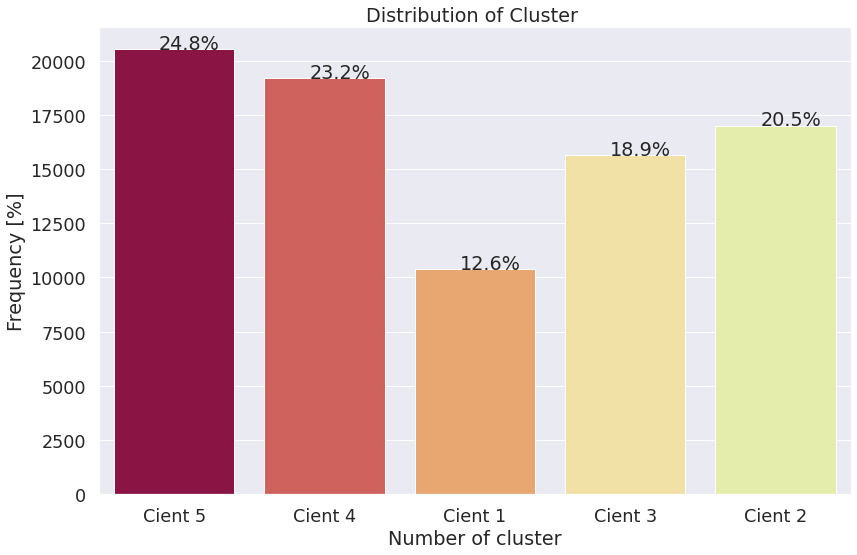

In [ ]:
mapping = {0:'Cient 1', 1:'Cient 2', 2:'Cient 3', 3:'Cient 4', 4:'Cient 5'}

label_T3,data_rfm_T3,SS_T3,ari_T3=data_clustering_time(df_Olist_T3,5,mapping)

In [ ]:
#dispaching each cluster in the right name
#first Trimester
mapping_T1= {'Cient 1':'Cient 3', 'Cient 3':'Cient 2',
           'Cient 2':'Cient 1', 'Cient 4':'Cient 4', 
           'Cient 5':'Cient 5'}
data_rfm_T1['Cluster'] =[mapping_T1[i] for i in data_rfm_T1['Cluster']]
a=pd.DataFrame(data_rfm_T1.Cluster.value_counts(),columns=['Cluster'])
a.rename(columns={"Cluster": "1_semeter"}, inplace=True)

#after 6 mounths T2
mapping_T2 = {'Cient 3':'Cient 1', 'Cient 4':'Cient 2',
           'Cient 5':'Cient 3', 'Cient 1':'Cient 4', 
           'Cient 2':'Cient 5'}
data_rfm_T2['Cluster'] =[mapping_T2[i] for i in data_rfm_T2['Cluster']]
b=pd.DataFrame(data_rfm_T2.Cluster.value_counts(),columns=['Cluster'])
b.rename(columns={"Cluster": "2_semeters "}, inplace=True)

#after 12 mounths T3
mapping_T3 = {'Cient 4':'Cient 1', 'Cient 2':'Cient 2',
           'Cient 1':'Cient 3', 'Cient 3':'Cient 4', 
           'Cient 5':'Cient 5'}
data_rfm_T3['Cluster'] =[mapping_T3[i] for i in data_rfm_T3['Cluster']]
c=pd.DataFrame(data_rfm_T3.Cluster.value_counts(),columns=['Cluster'])
c.rename(columns={"Cluster": "3_semeters"}, inplace=True)

#after 18 mounths T4
data_rfm_T4=data_rfm.copy()
d=pd.DataFrame(data_rfm_T4.Cluster.value_counts(),columns=['Cluster'])
d.rename(columns={"Cluster": "4_semeters"}, inplace=True)

In [ ]:
result = pd.concat([a,b,c,d], axis=1)
result

1_semeter  2_semeters   3_semeters  4_semeters
Cient 5       3840         9404       20541       24560
Cient 2       3145         5318       17016       19706
Cient 1       2808         9207       15644       21667
Cient 4       2657        11330       10402       17363
Cient 3       1619         7966       19226       11820

Text(0, 0.5, 'count of cluster')

<Figure size 864x576 with 0 Axes>

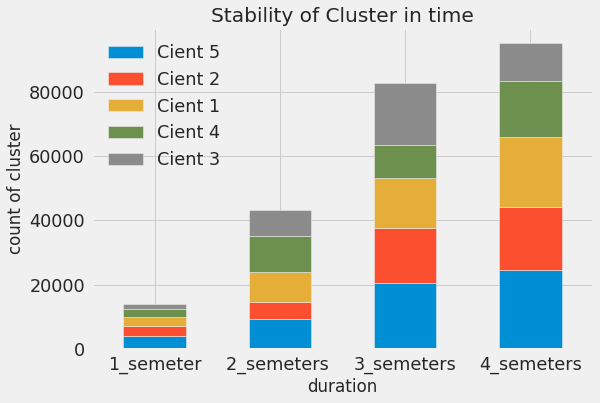

In [ ]:
plt.style.use('fivethirtyeight') 
plt.figure(figsize=(12,8))
result.T.plot(kind="bar", stacked=True, rot=0)
plt.title("Stability of Cluster in time")
plt.xlabel("duration")
plt.ylabel("count of cluster")

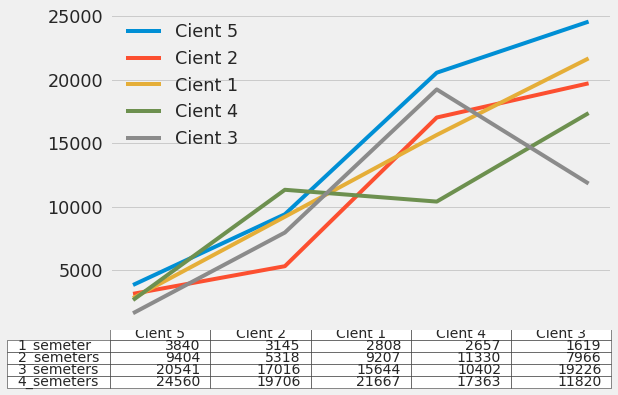

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.get_xaxis().set_visible(False)   # Hide Ticks
df=result.T
df.plot(table=np.round(df, 2), ax=ax)

<Figure size 864x576 with 0 Axes>

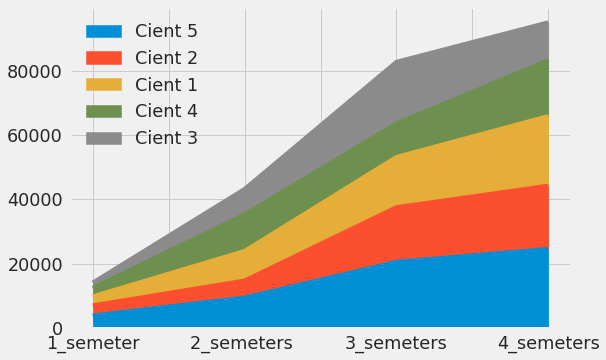

In [ ]:
#Draw an area plot for the DataFrame data
plt.style.use('fivethirtyeight') 
plt.figure(figsize=(12,8))

df=result.T
df.plot(kind='area', stacked=True)

plt.show(block=True);

**Silhouette Score in time**

In [ ]:
ss_score=[SS_T1,SS_T2,SS_T3,SS_total]

score=pd.DataFrame(ss_score,
                   index=['Semester1','Semester2','Semester3','Semester4'],
                   columns=['Silouette_score'])

(0.0, 0.5)

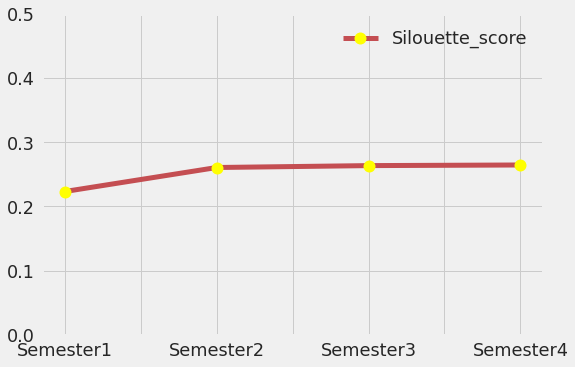

In [ ]:
score.plot( marker='o',
           markerfacecolor='yellow',
           markersize=12,
           stacked=True,
           color='r',
           linewidth=5)
plt.ylim(0,0.5)

In [ ]:
score     

Silouette_score
Semester1         0.223355
Semester2         0.260774
Semester3         0.263736
Semester4         0.264712

### 3-6 Contrat de maintenance 

In [ ]:
#Semester1
mapping = {'Cient 1':'CientT1_1', 'Cient 2':'CientT1_2',
           'Cient 3':'CientT1_3','Cient 4':'CientT1_4',
           'Cient 5':'CientT1_5'}
df_Olist_T1["Semester1"] = data_rfm_T1['Cluster']
df_Olist_T1['Semester1'] =[mapping[i] for i in df_Olist_T1['Semester1']]
client_T1=df_Olist_T1[['customer_unique_id',
                       'Semester1']].set_index('customer_unique_id')

#after one semester
#recaling cluster
mapping = {'Cient 1':'CientT2_1', 'Cient 2':'CientT2_2',
           'Cient 3':'CientT2_3','Cient 4':'CientT2_4',
           'Cient 5':'CientT2_5'}
df_Olist_T2["Semester2"] = data_rfm_T2['Cluster']
df_Olist_T2['Semester2'] =[mapping[i] for i in df_Olist_T2['Semester2']]
client_T2=df_Olist_T2[['customer_unique_id',
                       'Semester2']].set_index('customer_unique_id')

#after 2 semesters
mapping = {'Cient 1':'CientT3_4', 'Cient 2':'CientT3_2',
           'Cient 3':'CientT3_1','Cient 4':'CientT3_3',
           'Cient 5':'CientT3_5'}
df_Olist_T3["Semester3"] = data_rfm_T3['Cluster']
df_Olist_T3['Semester3'] =[mapping[i] for i in df_Olist_T3['Semester3']]
client_T3=df_Olist_T3[['customer_unique_id',
                       'Semester3']].set_index('customer_unique_id')

#after 3 semesters
mapping = {0:'CientT4_1', 1:'CientT4_2',
           2:'CientT4_3',3:'CientT4_4',
           4:'CientT4_5'}
df_Olist_T4["Semester4"] = labels
df_Olist_T4['Semester4'] =[mapping[i] for i in df_Olist_T4['Semester4']]
#df_Olist_T4.reset_index(inplace=True)
client_total=df_Olist_T4[['customer_unique_id','Semester4','Monetary']]
client_total=client_total[['customer_unique_id',
                           'Semester4',
                           'Monetary']].set_index('customer_unique_id')


In [ ]:
df_Olist_T4.Semester4.value_counts()

CientT4_5    24560
CientT4_1    21667
CientT4_2    19706
CientT4_4    17363
CientT4_3    11820
Name: Semester4, dtype: int64

In [ ]:
client_total.sample(2)

Semester4  Monetary
customer_unique_id                                   
613e666e3bca361445747f748a2980f1  CientT4_5     52.92
f4b13435b9071903e0d4598e330a0bce  CientT4_2     51.75

In [ ]:
#dataframe to Sankey graphe
result_sankly = pd.concat([client_T1,
                           client_T2,
                           client_T3,
                           client_total],axis=1)


In [ ]:
genSankey(result_sankly,cat_cols=['Semester2',
                                  'Semester3','Semester4'],
          value_cols='Monetary',
          title='Sankey Diagram')


<Figure size 1080x576 with 0 Axes>

#4  OPTICS :Ordering Points To Identify the Clustering Structure

Essayaons maintenant un autre algorithme avec d'autre variables pour voir le comportement du client par rapport au produits proposés sur la plateforme  produit et le vendeur

In [ ]:
Var_dbs=[ 'price_mean', 'order_item_mean', 'product_nbr', 'seller_Nbr',
        'Frequency_age','payment_installments_sum','age','item_Monetary']

In [ ]:
#Préprocessing of dataframes of each trimester
df_Olist_T2=df_Olist_T2[~df_Olist_T2.index.isin(VIP)]
df_Olist_T2=feature_engineering(df_Olist_T2)
data_db=df_client[Var_dbs]
data_sample=data_db.sample(40000, random_state=50)
data_scaled_minmax,data_scaled_Standard,data_scaled_Quantile=scaled(data_sample)

## 4-1 OPTICS+QuantileTransformer

In [ ]:
from sklearn.cluster import OPTICS
X=data_scaled_Quantile.copy()
#X=X.drop('cluster', axis=1)
clustering = OPTICS(min_samples=2*len(X.columns),
                    xi=.03,
                    min_cluster_size=.03)

# Run the fit
cluster=clustering.fit(X).labels_
X['cluster']= cluster
X['cluster'].value_counts()

 2    16669
 1    13461
 0     4881
-1     1908
 4     1699
 3     1382
Name: cluster, dtype: int64

In [ ]:
from sklearn.cluster import OPTICS
X=data_scaled_Quantile.copy()
#X=X.drop('cluster', axis=1)
clustering = OPTICS(min_samples=2*len(X.columns),
                    xi=.03,
                    min_cluster_size=.03)

# Run the fit
cluster=clustering.fit(X).labels_
X['cluster']= cluster
X['cluster'].value_counts()

 2    16669
-1     9158
 1     6218
 0     4874
 4     1699
 3     1382
Name: cluster, dtype: int64

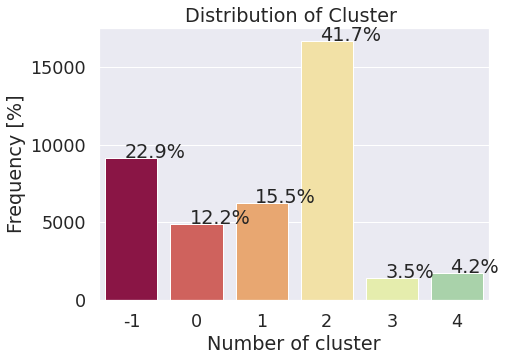

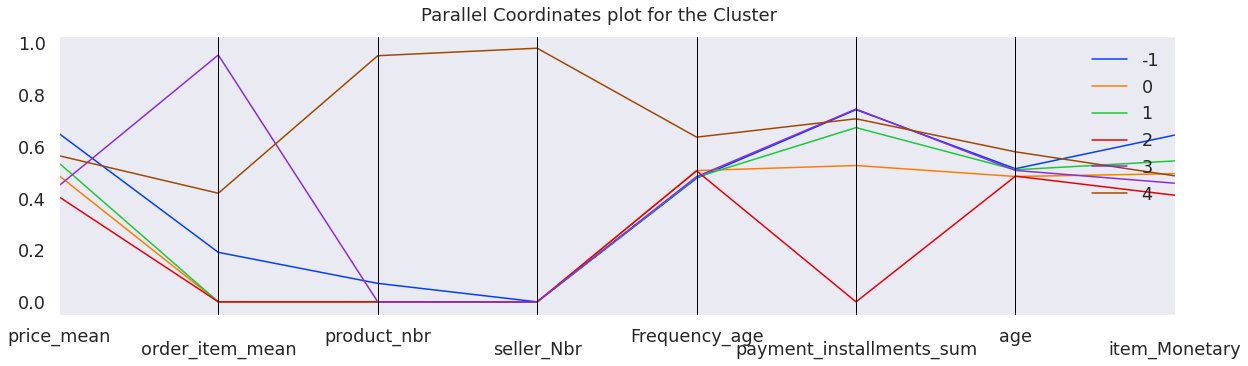

In [ ]:
#display result of clustering
X_quant=data_scaled_Quantile.copy()
X_quant.loc[:,'Cluster'] =cluster
comparaison(X_quant,Var_dbs)

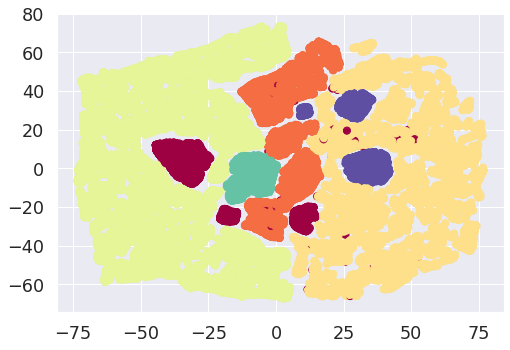

In [ ]:
tsne_ = TSNE(n_components = 2,
             init='pca',
             random_state=42).fit_transform(data_scaled_Quantile)
plt.scatter(tsne_[:, 0], tsne_[:, 1], c=cluster, s=50, cmap=cmap)

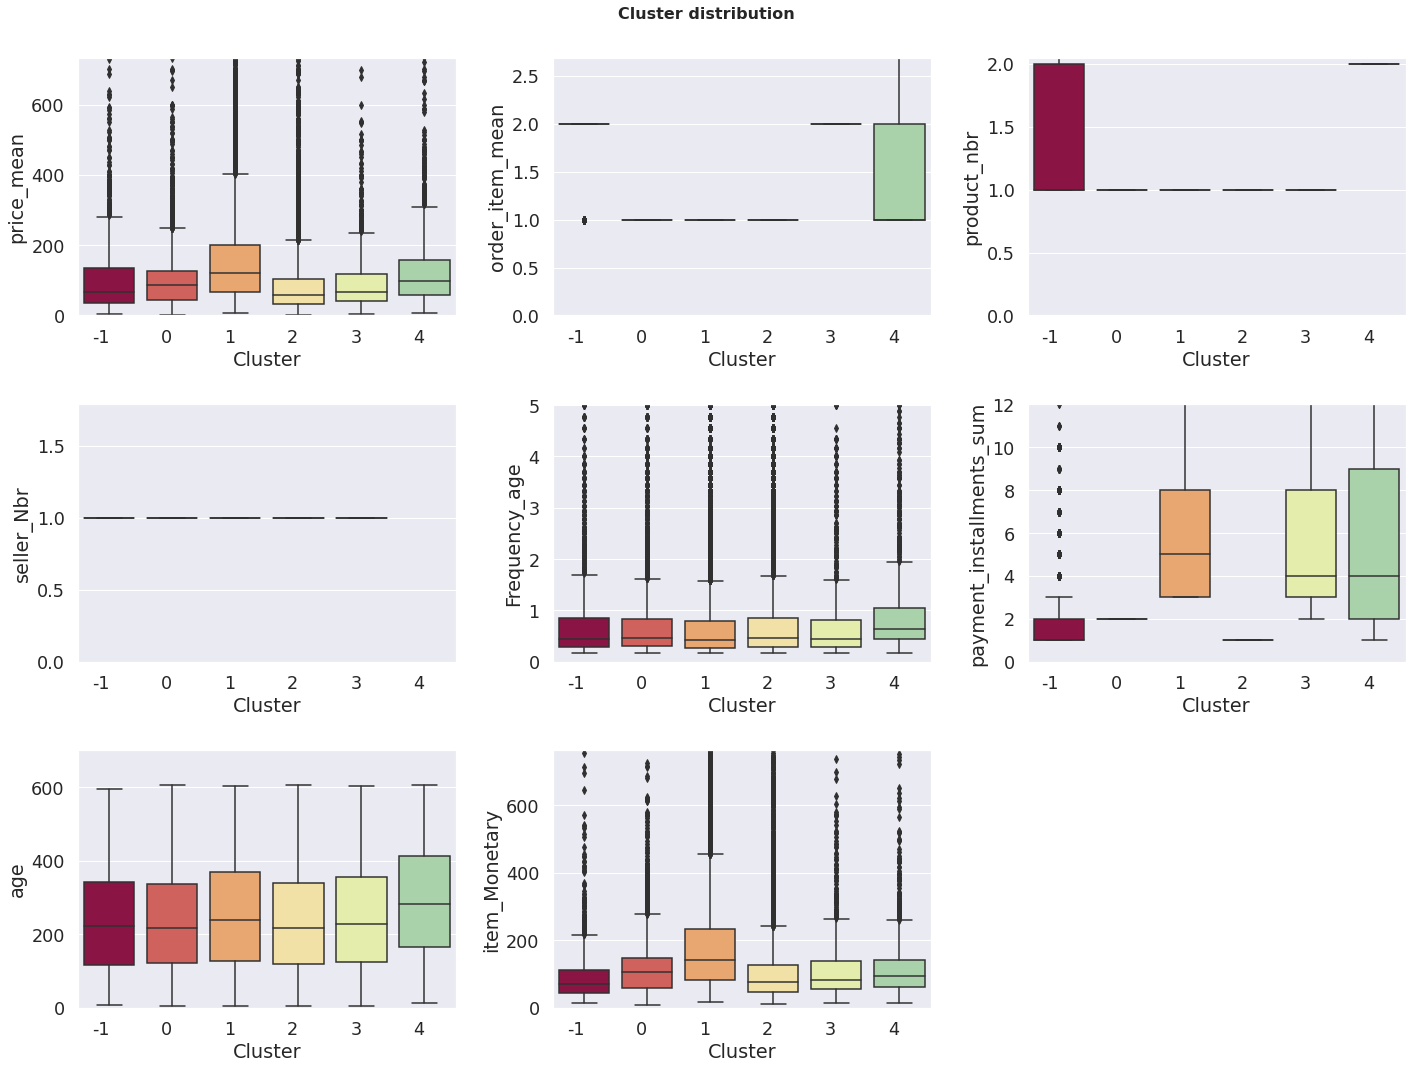

In [ ]:
# Plotting boxplots of each variables data for each cluster
data_sample['Cluster'] = cluster
distribution(data_sample,Var_dbs)

## 4-2 OPTICS + MinMaxScaler

In [ ]:
X=data_scaled_minmax.copy()
#X=X.drop('cluster', axis=1)
clustering = OPTICS(min_samples=2*len(X.columns),
                    xi=.05,
                    min_cluster_size=.05)

# Run the fit
cluster=clustering.fit(X).labels_
X['cluster']= cluster
X['cluster'].value_counts()

 2    16669
 1    13505
 0     4904
 3     2529
-1     2393
Name: cluster, dtype: int64

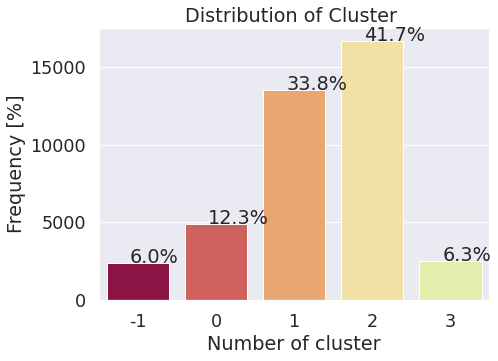

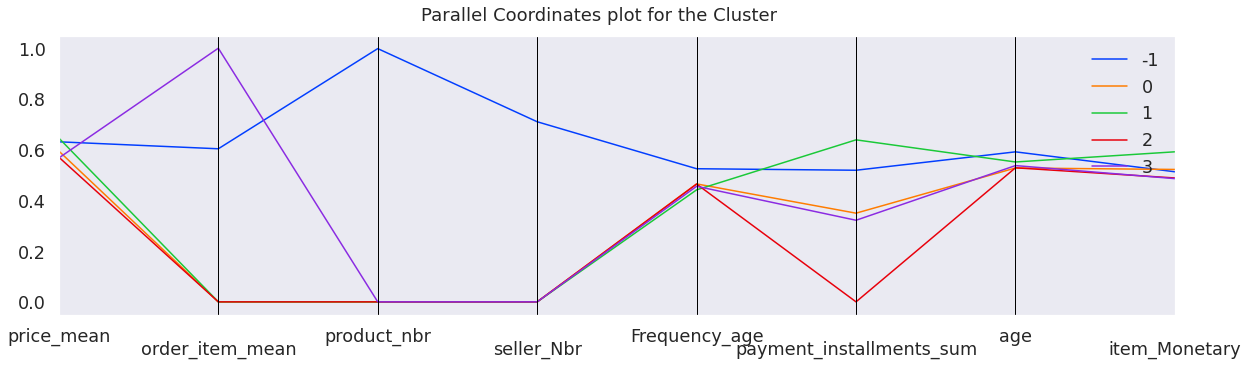

In [ ]:
X=data_scaled_minmax.copy()
X.loc[:,'Cluster'] = cluster
comparaison(X,Var_dbs)

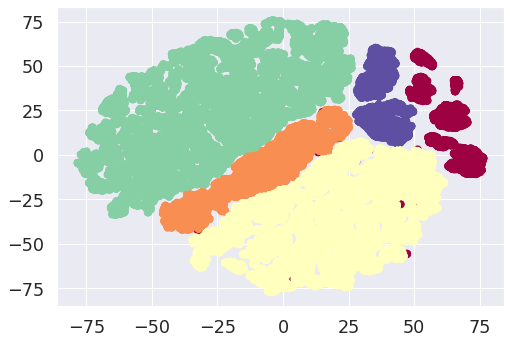

In [ ]:
tsne_ = TSNE(n_components = 2,
             init='pca',
             random_state=42).fit_transform(data_scaled_minmax)
plt.scatter(tsne_[:, 0], tsne_[:, 1], c=cluster, s=50, cmap=cmap)

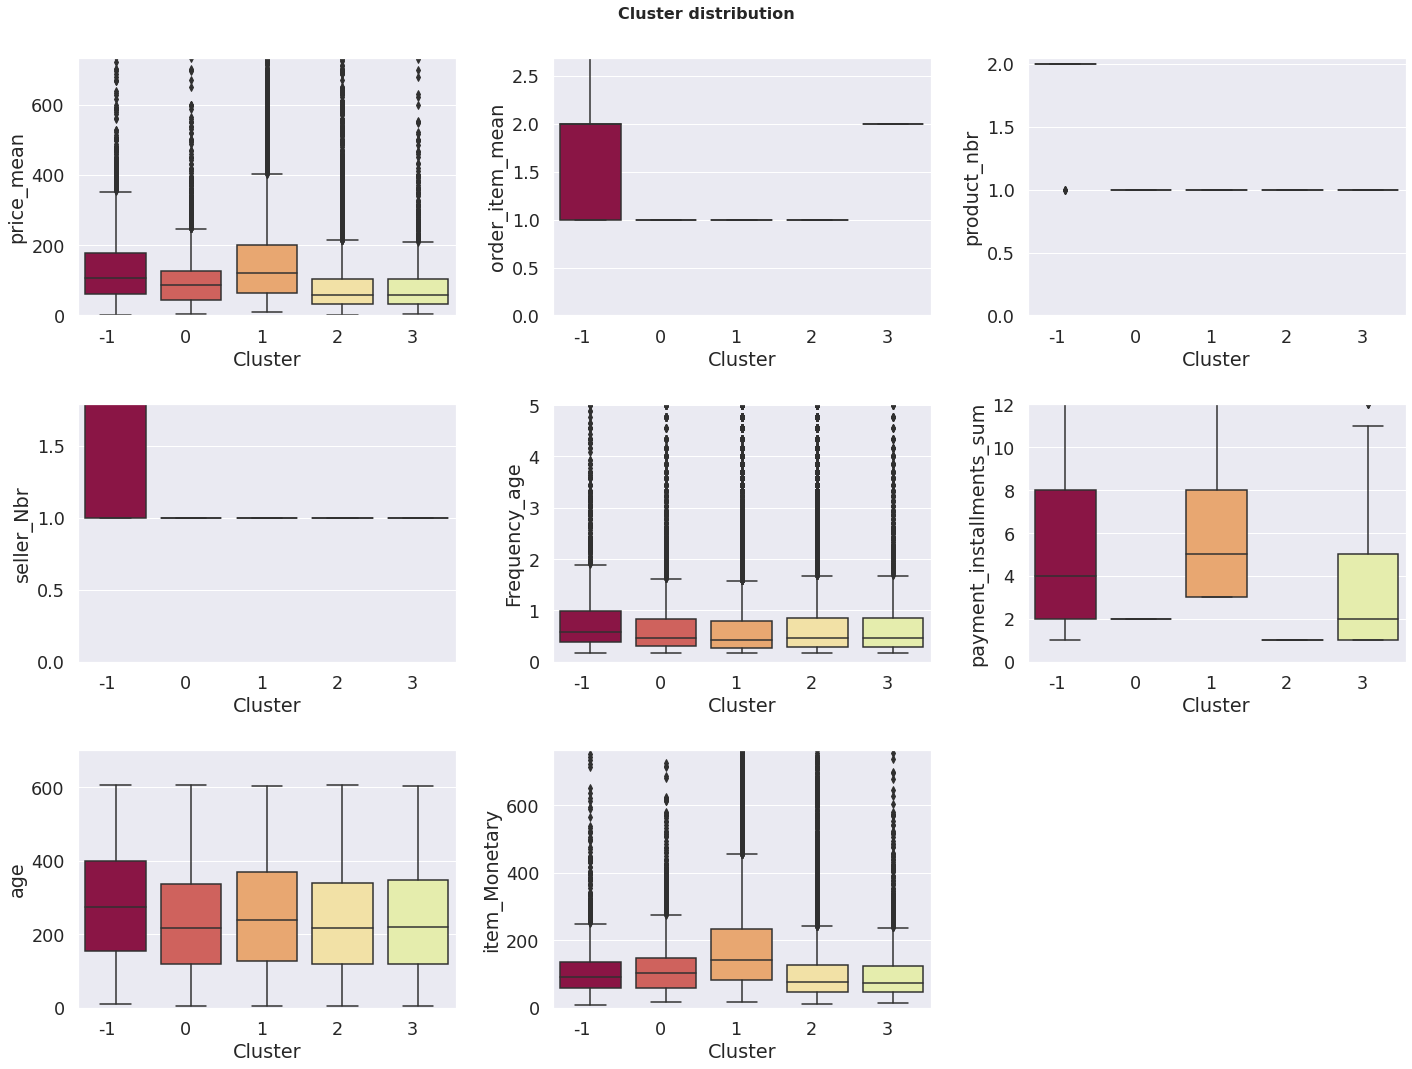

In [ ]:
# Plotting boxplots of each variables data for each cluster
data_sample['Cluster'] = cluster
distribution(data_sample,Var_dbs)

## 4-3 OPTICS + StandardScaler

In [ ]:
X=data_scaled_Standard.copy()
#X=X.drop('cluster', axis=1)
clustering = OPTICS(min_samples=2*len(X.columns),
                    xi=.05,
                    min_cluster_size=.05)

# Run the fit
cluster=clustering.fit(X).labels_
X['cluster']= cluster
X['cluster'].value_counts()


 0    18412
 1    16667
 2     2529
-1     2392
Name: cluster, dtype: int64

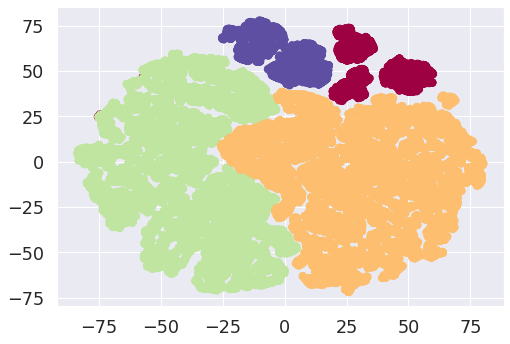

In [ ]:
tsne_ = TSNE(n_components = 2,
             init='pca',
             random_state=42).fit_transform(data_scaled_Standard)
plt.scatter(tsne_[:, 0], tsne_[:, 1], c=cluster, s=50, cmap=cmap)

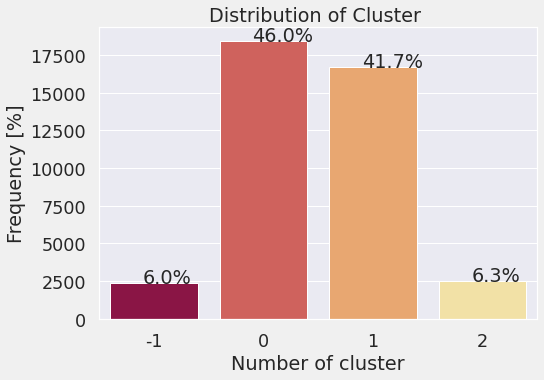

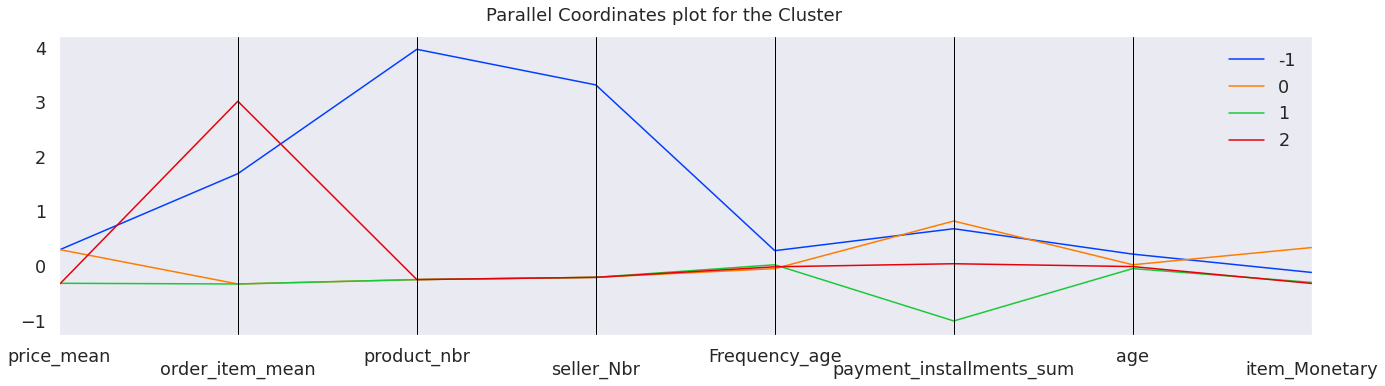

In [ ]:
X_std=data_scaled_Standard.copy()
X_std.loc[:,'Cluster'] = cluster
comparaison(X_std,Var_dbs)

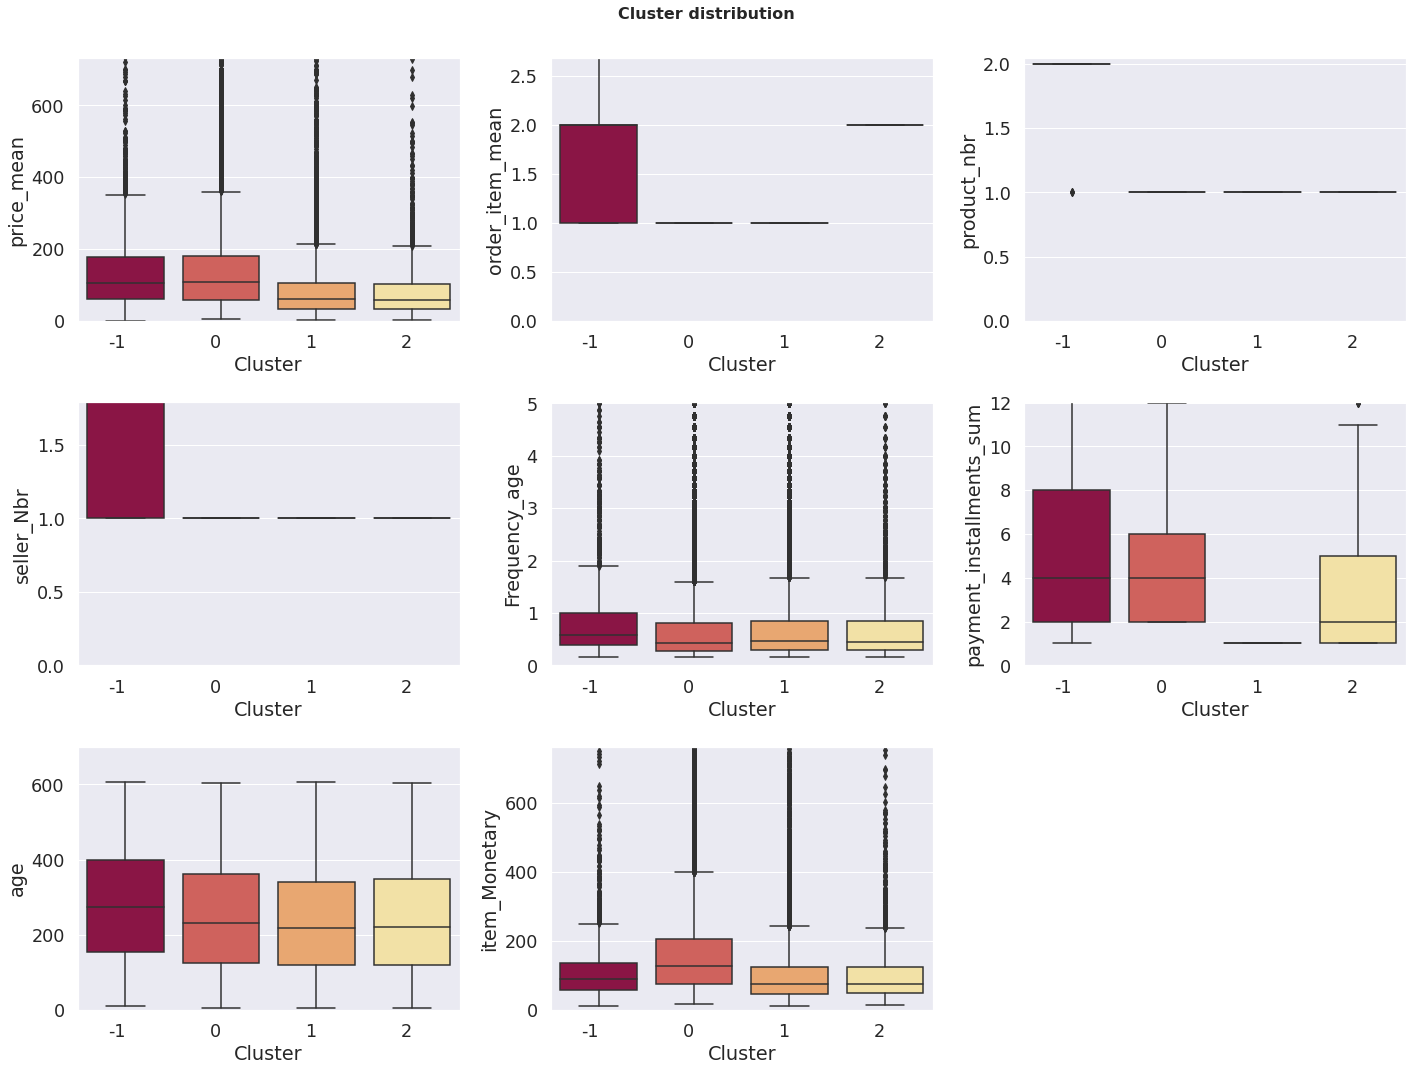

In [ ]:
# Plotting boxplots of each variables data for each cluster
data_sample['Cluster'] = cluster
distribution(data_sample,Var_dbs)

In [ ]:
ARI_scores=stability(data_scaled_Standard,clustering, nb_itr=3)
SS_quantile=silhouette_score(data_scaled_Standard, cluster)
print("Silhouette Coefficient: %0.3f"% SS_quantile)

Silhouette Coefficient: 0.229


## 4-4 Stabilité

In [ ]:
X=data_scaled_Quantile.copy()
min_s=2*len(X.columns)
clustering = OPTICS(min_samples=min_s, xi=.03, min_cluster_size=.03)

score_minmax,Sc_minmax=stability(data_scaled_minmax,clustering, nb_itr=6)
score_Standard,Sc_Standard=stability(data_scaled_Standard,
                                     clustering, 
                                     nb_itr=6)
score_Quantile,Sc_Quantile=stability(data_scaled_Quantile,
                                     clustering,
                                     nb_itr=23)

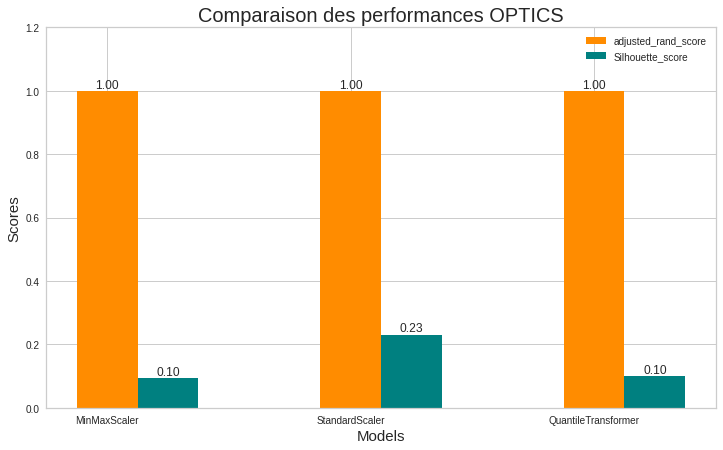

In [ ]:

#display scores of  each Scaler
columns_train=['adjusted_rand_score','Silhouette_score']
index = ['MinMaxScaler',"StandardScaler","QuantileTransformer"]
tab_score=pd.DataFrame([[score_minmax,Sc_minmax],
                        [score_Standard,Sc_Standard],
                        [score_Quantile,Sc_Quantile],
                      ],index = index,columns=columns_train ).round(3)

#plot bar each Scaler 
barWidth = 0.25# the width of the bars

r1 = np.arange(len(tab_score))
r2 = [x + barWidth for x in r1]
fig, ax = plt.subplots(figsize=(12,7))

rec1=ax.bar(r1,
            tab_score['adjusted_rand_score'],
            color='darkorange',
            width=barWidth,
            label='adjusted_rand_score')
rec2=ax.bar(r2,
            tab_score['Silhouette_score'],
            color='teal',
            width=barWidth,
            label='Silhouette_score')

for rect in rec1 :
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
            '{:1.2f}'.format(height),
            ha='center', va='bottom')
for rect in rec2 :
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
            '{:1.2f}'.format(height),
            ha='center', va='bottom')
# add some text for labels, title and axes ticks
ax.set_title('Comparaison des performances OPTICS', fontsize = 20)
ax.set_xlabel('Models', fontsize = 15)
ax.set_ylabel('Scores', fontsize = 15)
ax.set_ylim(top=1.2)
plt.xticks(r1, tab_score.index)
ax.legend()
plt.show()

# 5 Hierarchial Clustering

In [ ]:
Var=['age', 'Monetary', 'price_mean',
       'freight_value_mean', 'finish_order', 'review_score_min',
       'item_Monetary', 'catg', 'nbr_payment_type',
       'review_message_len']
data_rfm_sch=df_client[Var].sample(30000, random_state=50)
#data scale
data_scaled_minmax,data_scaled_Standard,data_scaled_Quantile=scaled_johnson(data_rfm_sch)


## 5-1 Hierarchial Clustering + QuantileTransformer

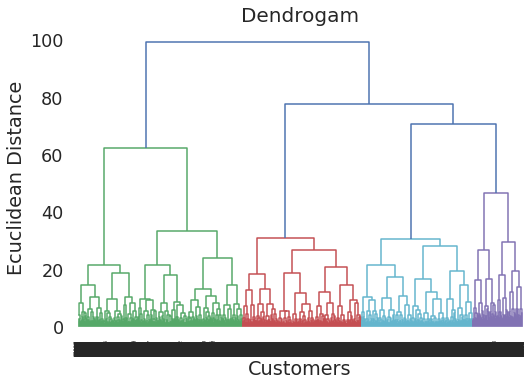

In [ ]:
#let's draw the dendrograms for our data points. 
#We will use the scipy.cluster.hierarchy library for that purpose
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(data_scaled_Quantile,
                                        method = 'ward'))
plt.title('Dendrogam', fontsize = 20)
plt.xlabel('Customers')
plt.ylabel('Ecuclidean Distance')
plt.show()

Le nombre optimal de custers = 5 et appliquant  Agglomerative Hierarchical Clustering :

In [ ]:
# creating object hc of class AgglomerativeClustering()
hc=AgglomerativeClustering(n_clusters=5,
                           affinity="euclidean",
                           linkage="ward")


In [ ]:
#Labels
y_hc=hc.fit_predict(data_scaled_Quantile)

In [ ]:
y_hc
unique, counts = np.unique(y_hc, return_counts=True)
dict(zip(unique, counts))


{0: 7970, 1: 3357, 2: 7517, 3: 6186, 4: 4970}

In [ ]:
mapping = {0:'Cient 1', 1:'Cient 2', 2:'Cient 3',
           3:'Cient 4', 4:'Cient 5'}
data_rfm_sch['Cluster']=y_hc
X=data_scaled_Quantile.copy()
X['Cluster']=y_hc

data_rfm_sch['Cluster'] =[mapping[i] for i in data_rfm_sch['Cluster']]
X['Cluster'] =[mapping[i] for i in X['Cluster']]

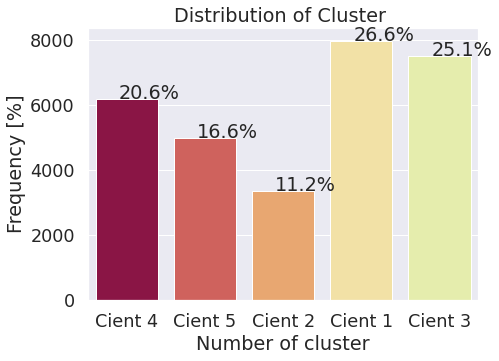

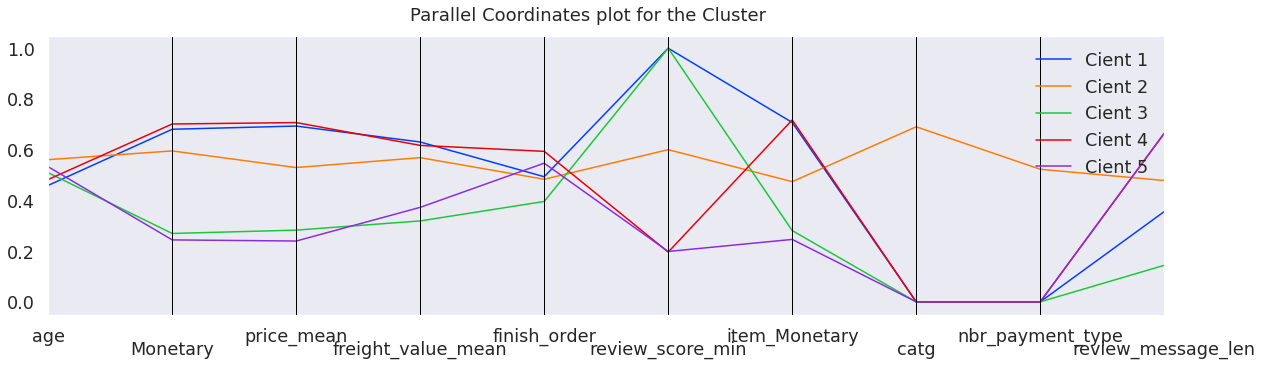

In [ ]:
comparaison(X,Var)

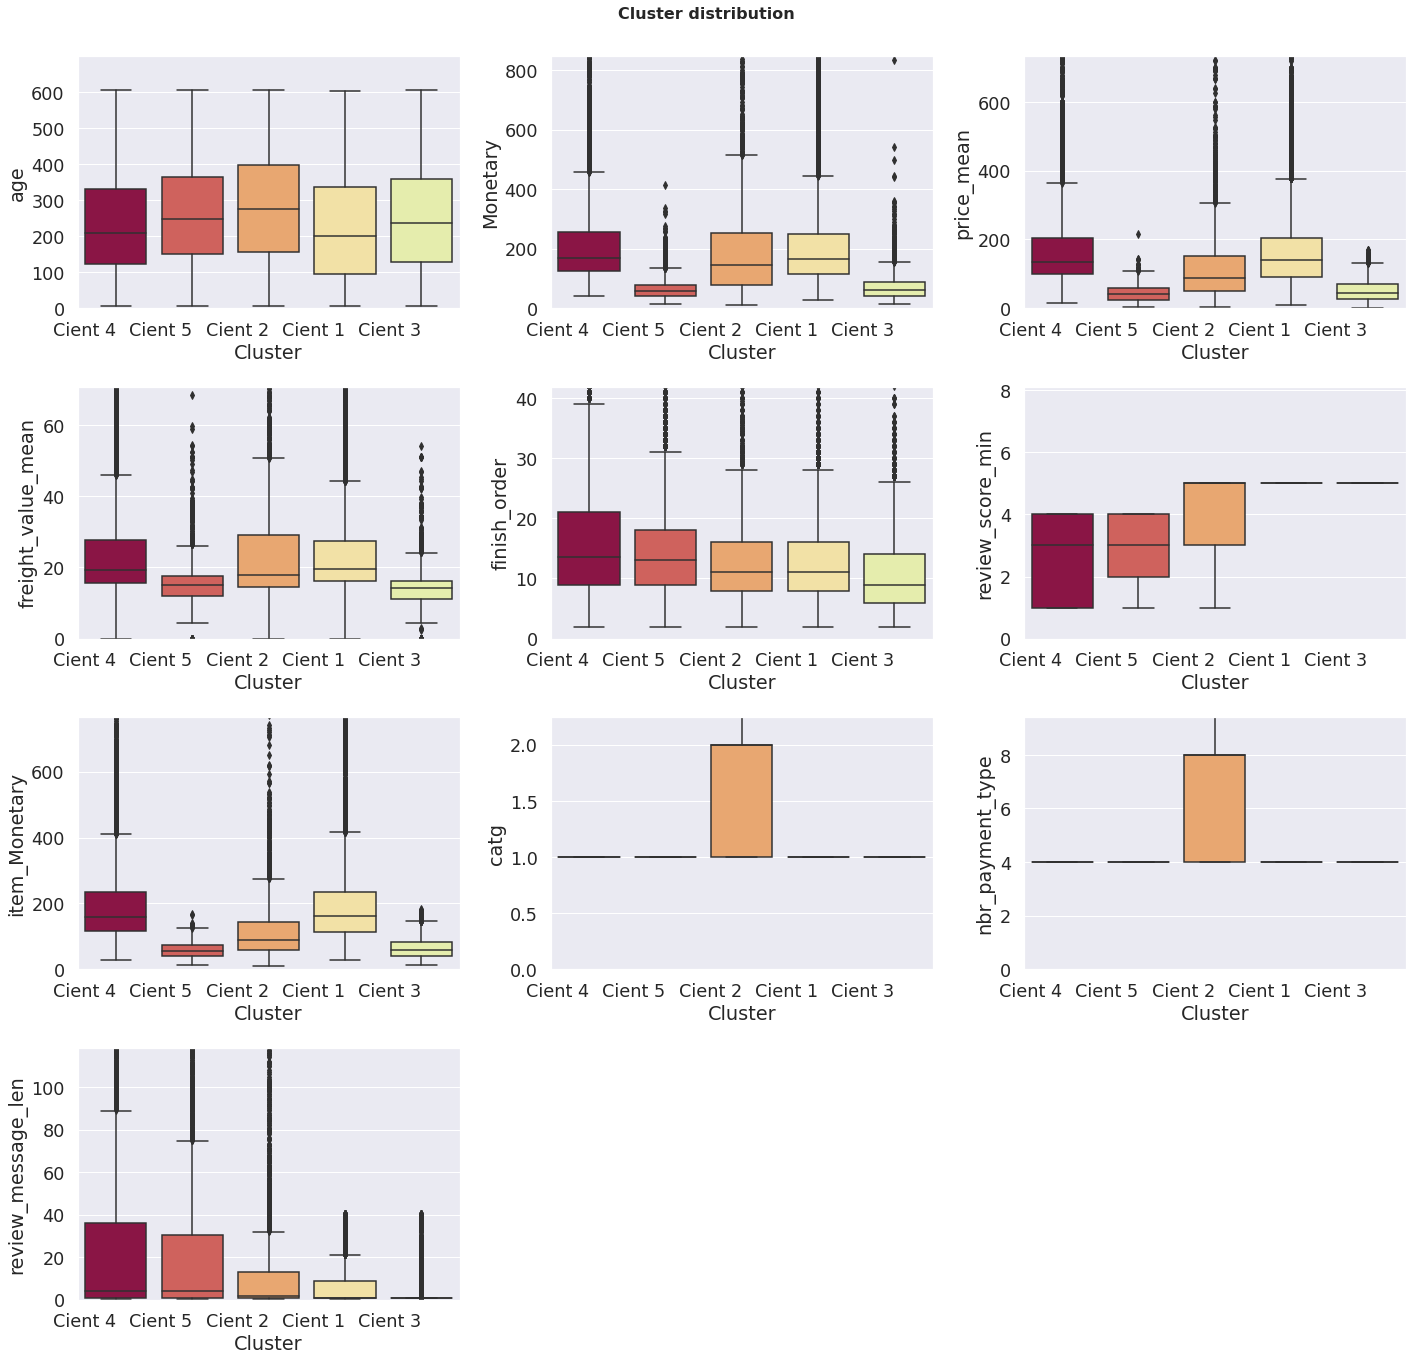

In [ ]:
# Plotting boxplots of each variables data for each cluster
distribution(data_rfm_sch,Var)

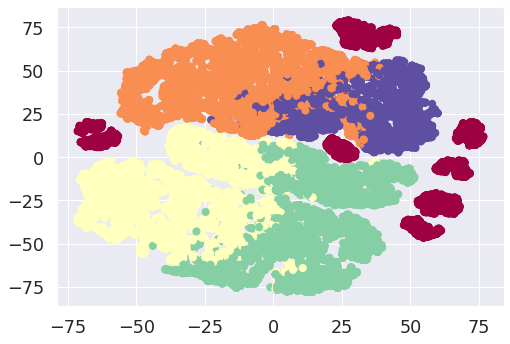

In [ ]:
tsne_ = TSNE(n_components = 2,
             init='pca',
             random_state=42).fit_transform(data_scaled_Quantile)
plt.scatter(tsne_[:, 0], tsne_[:, 1], c=y_hc, s=50, cmap=cmap)

## 5-2 Hierarchial Clustering + MinMaxscaler

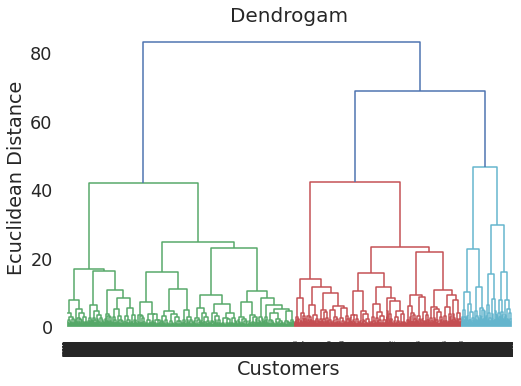

In [ ]:
#let's draw the dendrograms for our data points. 
#We will use the scipy.cluster.hierarchy library for that purpose
dendrogram = sch.dendrogram(sch.linkage(data_scaled_minmax, 
                                        method = 'ward'))
plt.title('Dendrogam', fontsize = 20)
plt.xlabel('Customers')
plt.ylabel('Ecuclidean Distance')
plt.show()

Le nombre optimal des cluster est 6

In [ ]:
# creating object hc of class AgglomerativeClustering()
hc_minmax=AgglomerativeClustering(n_clusters=6,
                                  affinity="euclidean",
                                  linkage="ward")
y_hc_minmax=hc_minmax.fit_predict(data_scaled_minmax)

In [ ]:
data_rfm_ch_minmax=data_rfm_sch.copy()
data_rfm_ch_minmax['Cluster']=y_hc_minmax
mapping = {0:'Cient 1', 1:'Cient 2', 2:'Cient 3',
           3:'Cient 4',4:'Cient 5',5:'Cient 6'}
X=data_scaled_minmax.copy()
X['Cluster']=y_hc_minmax

X['Cluster'] =[mapping[i] for i in X['Cluster']]

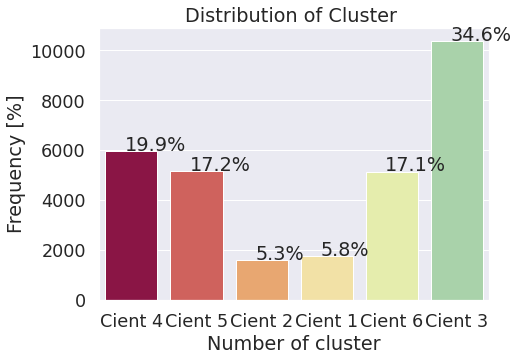

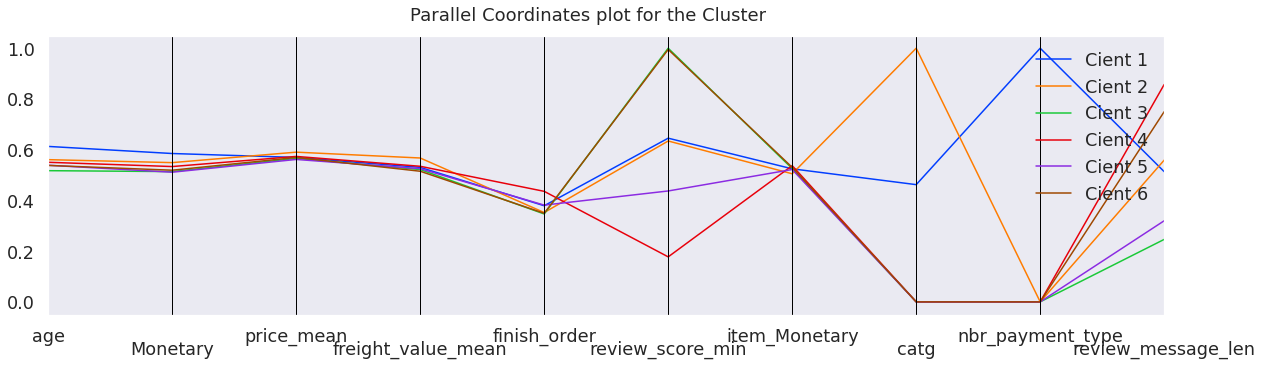

In [ ]:
comparaison(X,Var)

## 5-3 Hierarchial Clustering + StadarScaler

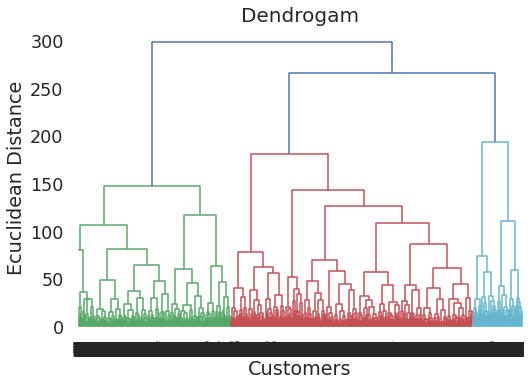

In [ ]:
#let's draw the dendrograms for our data points. 
#We will use the scipy.cluster.hierarchy library for that purpose

dendrogram = sch.dendrogram(sch.linkage(data_scaled_Standard,
                                        method = 'ward'))
plt.title('Dendrogam', fontsize = 20)
plt.xlabel('Customers')
plt.ylabel('Ecuclidean Distance')
plt.show()

Le nombre optimal des cluster est 5

In [ ]:
# creating object hc of class AgglomerativeClustering()
hc_std=AgglomerativeClustering(n_clusters=5,
                               affinity="euclidean",
                               linkage="ward")
#Lables
y_hc_std=hc_std.fit_predict(data_scaled_Standard)

In [ ]:
data_rfm_ch_std=data_rfm_sch.copy()
data_rfm_ch_std['Cluster']=y_hc_std
X=data_scaled_Standard.copy()
X['Cluster']=y_hc_std
mapping = {0:'Cient 1', 1:'Cient 2', 2:'Cient 3',
           3:'Cient 4',4:'Cient 5'}
X['Cluster'] =[mapping[i] for i in X['Cluster']]
data_rfm_ch_std['Cluster'] =[mapping[i] for i in data_rfm_ch_std['Cluster']]

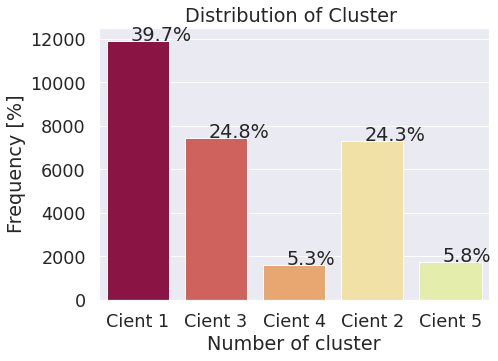

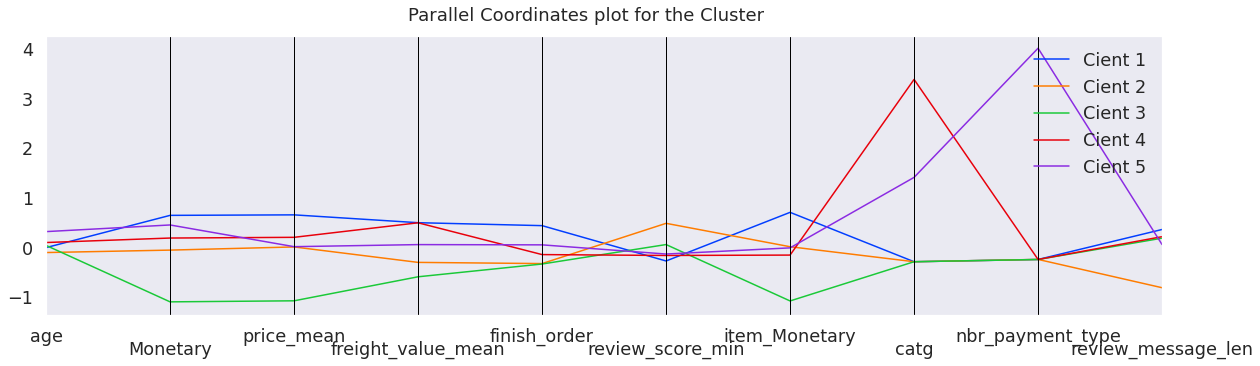

In [ ]:
comparaison(X,Var)

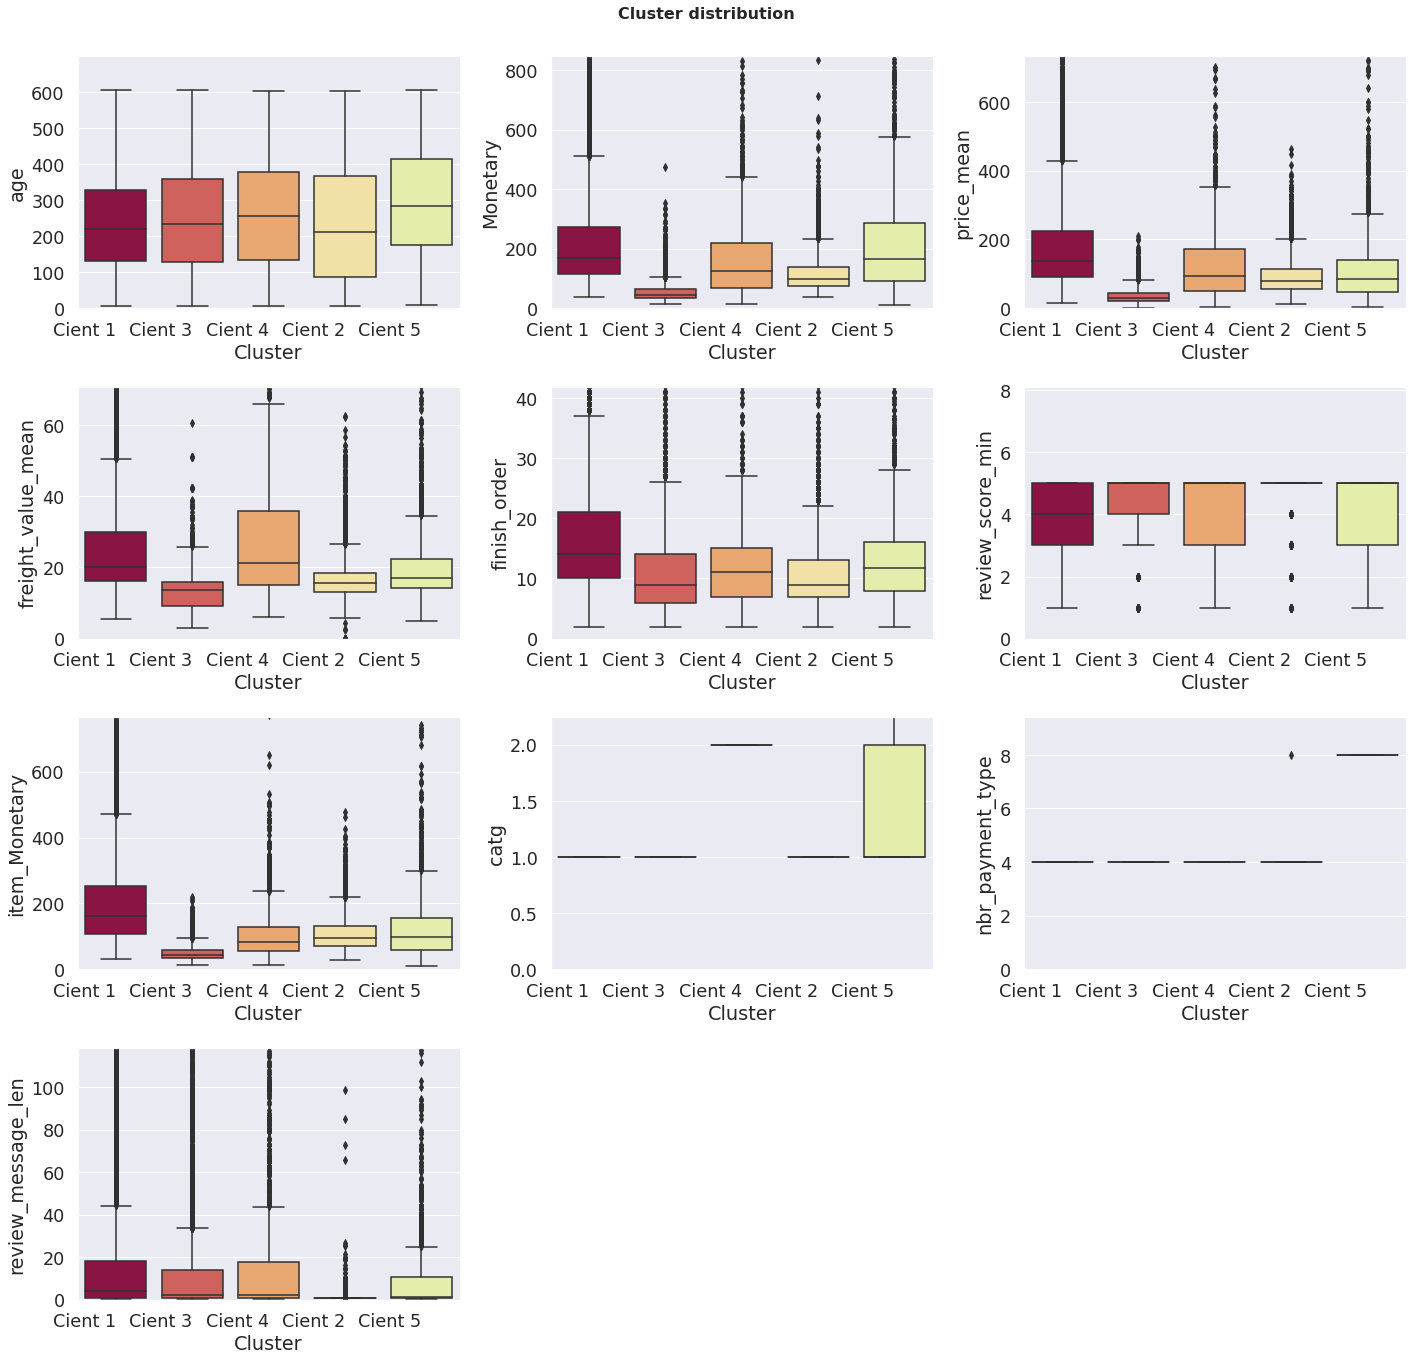

In [ ]:
# Plotting boxplots of each variables data for each cluster
distribution(data_rfm_ch_std,Var)

## 5-4 Stabilité

In [ ]:
#Score for MinmaxScaler
hc_minmax=AgglomerativeClustering(n_clusters=6,
                                  affinity="euclidean",
                                  linkage="ward")
score_minmax,Sc_minmax=stability(data_scaled_minmax,hc_minmax, nb_itr=2)

#Score for standardScaler
hc_std=AgglomerativeClustering(n_clusters=5,
                               affinity="euclidean",
                               linkage="ward")
score_Standard,Sc_Standard=stability(data_scaled_Standard,hc_std, nb_itr=2)

#Score for QuantileTransformer
hc=AgglomerativeClustering(n_clusters=5,
                           affinity="euclidean",
                           linkage="ward")
score_Quantile,Sc_Quantile=stability(data_scaled_Quantile,hc, nb_itr=2)

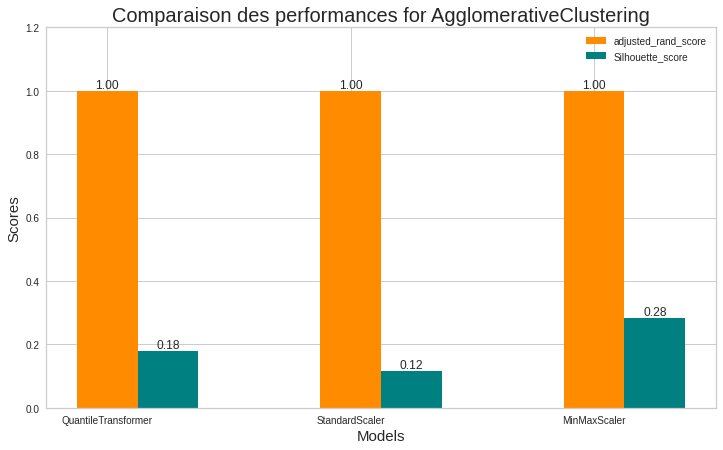

In [ ]:
#display scores of  each Scaler
columns_train=['adjusted_rand_score','Silhouette_score']
index = ['QuantileTransformer',"StandardScaler","MinMaxScaler"]
tab_score=pd.DataFrame([[score_Quantile,Sc_Quantile],
                        [score_Standard,Sc_Standard],
                        [score_minmax,Sc_minmax],
                        
                      ],index = index,columns=columns_train ).round(3)

#plot bar each Scaler 
barWidth = 0.25# the width of the bars

r1 = np.arange(len(tab_score))
r2 = [x + barWidth for x in r1]
fig, ax = plt.subplots(figsize=(12,7))

rec1=ax.bar(r1, tab_score['adjusted_rand_score'], color='darkorange',
            width=barWidth,  label='adjusted_rand_score')
rec2=ax.bar(r2, tab_score['Silhouette_score'], color='teal', 
            width=barWidth,  label='Silhouette_score')

for rect in rec1 :
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
            '{:1.2f}'.format(height),
            ha='center', va='bottom')
for rect in rec2 :
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
            '{:1.2f}'.format(height),
            ha='center', va='bottom')
# add some text for labels, title and axes ticks
ax.set_title('Comparaison des performances for AgglomerativeClustering', 
             fontsize = 20)
ax.set_xlabel('Models', fontsize = 15)
ax.set_ylabel('Scores', fontsize = 15)
ax.set_ylim(top=1.2)
plt.xticks(r1, tab_score.index)
ax.legend()
plt.show()